In [1]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from tensorflow.keras.callbacks import Callback
import numpy as np
import tensorflow as tf
from functools import partial

AUTOTUNE = tf.data.experimental.AUTOTUNE
from dask.diagnostics import ProgressBar
import pandas as pd
import tensorflow.keras.layers as layers
import json
from tensorflow.keras.optimizers import Adam
from tensorflow._api.v2.distribute import MirroredStrategy
from tensorflow.keras import layers
import datetime
import tqdm
import time
import argparse


ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/rampaln/envs/ml_env_v2/share/proj failed
2025-07-21 22:45:51.423450: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [234]:
df = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/Downscaling-with-AI-reveals-large-role-of-internal-variability-in-fine-scale-projections-of-climate-extremes/AI_large_ensemble/internal_variability_data/Multi_Model_Decomposition_pr_LE_IV_v160625_raw.nc')

In [235]:
df

<xarray.Dataset>
Dimensions:      (lon: 179, lat: 172, year: 141, GCM_variant: 59, time: 141)
Coordinates:
  * lon          (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat          (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
  * year         (year) int64 1960 1961 1962 1963 1964 ... 2097 2098 2099 2100
  * GCM_variant  (GCM_variant) object 'ACCESS-ESM1-5_r10i1p1f1' ... 'CanESM5_...
    GCM          (GCM_variant) object ...
  * time         (time) datetime64[ns] 1960-02-01 1961-02-01 ... 2100-02-01
Data variables:
    RX1Day_IV    (GCM_variant, year, lat, lon) float64 ...
    DJF_IV_pr    (GCM_variant, time, lat, lon) float64 ...

# Pseudo-warming doesn't work as I'd normally expect,

this might be a reflection of how the model learns relationships between variables when downscaling. 

We do experiments, by basically perturbing the model, and examining its response? We create some sort of heatmaps of what things look like

## Shifted the Grid slightly to the right, and the whole response was cooked?

In [2]:
os.chdir(r'//nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/diffusion_models_byrn')

In [3]:
config_file = r'//nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/diffusion_models_byrn/models/Future_Hist_trained_Diffusion2_1000-0.0001-0.02_0.01pr_ACCESS-CM2/config_info.json'
config_file_for_test_data  = r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/diffusion_models_byrn/model_inference/metadata_ACCESS-CM2_diffusion.json'
#config_file = sys.argv[-1]
with open(config_file, 'r') as f:
    config = json.load(f)

In [4]:

# if args.config:
#     config_file_for_test_data = args.config
# elif args.dev:
#     config_file_for_test_data = r'./model_inference/metadata_all_gcms_v3_diffusion_dev.json'
# else:
#     config_file_for_test_data = r'./model_inference/metadata_all_gcms_v3_diffusion.json'
# # if sys.argv[-2] == '--dev':
# #     config_file_for_test_data = r'./model_inference/metadata_all_gcms_v3_diffusion_dev.json'

In [5]:

with open(config_file_for_test_data) as f:
    config_test_data = json.load(f)

USING_GAN = False

output_norm = 1

In [6]:
# 30 y period
historical_period = slice("1985","2014")
future_period = slice("2070","2099")


In [7]:
sys.path.append(r'//nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/diffusion_models_byrn')
from src.layers import *
from src.models import *
from src.gan import *
from src.process_input_training_data import *
from src.dm import ResidualDiffusion, DiffusionSchedule, EDMSchedule, PredictionCallbackDiffusion
from src.models_dm import build_diffusion_unet, build_diffusion_unet_v2, build_edm_unet, get_custom_dm_objects

In [8]:



def load_model_dm(model_name, model_dir, epoch=None, gan=False):
    if epoch is None:
        epoch_suffix = 'final'
    else:
        epoch_suffix = f'epoch_{epoch}'

    dm_path = f'{model_dir}/{model_name}/ema_generator_{epoch_suffix}.h5'
    dm_path_alt = f'{model_dir}/{model_name}/generator_{epoch_suffix}.h5'
    unet_path = f'{model_dir}/{model_name}/unet_{epoch_suffix}.h5'

    custom_objects_unet = {"BicubicUpSampling2D": BicubicUpSampling2D,
                        "SymmetricPadding2D": SymmetricPadding2D}
    custom_objects_dm_or_gan = get_custom_dm_objects() if not gan else custom_objects_unet

    if os.path.exists(dm_path):
        dm = tf.keras.models.load_model(dm_path,
                                        custom_objects=custom_objects_dm_or_gan,
                                        compile=False)
    else:
        dm = tf.keras.models.load_model(dm_path_alt,
                                        custom_objects=custom_objects_dm_or_gan,
                                        compile=False)
    
    with open(f'{model_dir}/{model_name}/config_info.json') as f:
        config = json.load(f)

        unet = tf.keras.models.load_model(unet_path, custom_objects=custom_objects_unet
                                          , compile=False)

    return dm, unet, config["ad_loss_factor"]

def preprocess_input_data_eval(config: dict, match_index = True):
    vegt, orog, he = prepare_static_fields(config)
    means = xr.open_dataset(config["mean"])
    stds = xr.open_dataset(config["std"])

    X = xr.open_dataset(config["train_x"])  # .sel(time = slice("2016", None))
    X['time'] = pd.to_datetime(X.time.dt.strftime("%Y-%m-%d"))

    y = xr.open_dataset(config["train_y"])#, chunks={"time": 5000})
    y['time'] = pd.to_datetime(y.time.dt.strftime("%Y-%m-%d"))# .sel(time = slice("2016", None))

    # LOCAL CHANGE
    if config.get("gcms_for_eval") and config.get("output_varname"):
        gcms = config["gcms_for_eval"]
        y = y[[config["output_varname"]]]
        y = y.sel(GCM=gcms)
        X = X.sel(GCM=gcms)

    try:
        y = y.drop("lat_bnds")
        y = y.drop("lon_bnds")

    except:
        pass

    # preare the training data
    stacked_X, y = prepare_training_data(config, X, y, means, stds, match_index = match_index)

    return stacked_X, y, vegt, orog, he

def compute_quantiles(df,quantiles, period):
    df = df.sel(time = period)
    # this removes instances which have negative precipitation (os the minimum value is -0.0001) 
    # due to the leakyrelu activation function in GANs
    df = df.where(df>0.0, 0.0)
    seasonal_rainfall = df.groupby('time.season').mean()
    df = df.where(df>1, np.nan)
    quantiled_rain = df.quantile(q = quantiles, dim =["time"], skipna =True)
    return quantiled_rain, seasonal_rainfall


def compute_signal(df, quantiles, historical_period, future_period):

    historical_quantiles, seasonal_rainfall = compute_quantiles(df, quantiles, historical_period)
    future_quantiles, future_rainfall = compute_quantiles(df, quantiles, future_period)

    cc_signal = 100 * (future_rainfall - seasonal_rainfall)/seasonal_rainfall
    signal = 100 * (future_quantiles - historical_quantiles)/historical_quantiles
    historical_quantiles = historical_quantiles.rename({"pr":"hist_quantiles"})
    future_quantiles = future_quantiles.rename({"pr": "future_quantiles"})
    seasonal_rainfall = seasonal_rainfall.rename({"pr":"hist_clim_rainfall"})
    future_rainfall = future_rainfall.rename({"pr":"future_clim_rainfall"})
    signal = signal.rename({"pr":"cc_signal"})
    cc_signal = cc_signal.rename({"pr":"seas_cc_signal"})
    dset = xr.merge([historical_quantiles, future_quantiles,
                     signal, cc_signal, seasonal_rainfall, future_rainfall])
    return dset

def create_output(X, y):
    y = y.isel(time=0).drop("time")
    y = y.expand_dims({"time": X.time.size})
    y['time'] = (('time'), X.time.to_index())
    return y

def expand_conditional_inputs(X, batch_size):
    expanded_image = tf.expand_dims(X, axis=0)  # Shape: (1, 172, 179)

    # Repeat the image to match the desired batch size
    expanded_image = tf.repeat(expanded_image, repeats=batch_size, axis=0)  # Shape: (batch_size, 172, 179)

    # Create a new axis (1) on the last axis
    expanded_image = tf.expand_dims(expanded_image, axis=-1)
    return expanded_image

            # orog_vector = self.wgan.expand_conditional_inputs(self.orog, self.batch_size)
            # #average_combined, orog_vector,time_of_year_combined, spatial_means_combined,
            # #                 spatial_stds_combined
            # unet_prediction = self.unet.predict([
            #                               self.x_input[0].values[:self.batch_size], orog_vector[:self.batch_size]], verbose=0)

            # gan_prediction = self.generator.predict([random_latent_vectors,random_latent_vectors1,
            #                               self.x_input[0], orog_vector,unet_prediction])
            #
            # VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV

In [10]:
def predict_batch_residual_solver(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
                                   scheduler=None, solver="heun", num_inference_steps=10):
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
        return intermediate + residual_pred

    if model_type != 'diffusion' or scheduler is None:
        raise Exception("A scheduler must be provided for diffusion model.")

    batch_size = tf.shape(data_batch)[0]
    residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))
    timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), dtype=tf.int32)
    intermediate = unet([data_batch, orog], training=False)

    prev_eps = None

    for i in tf.range(num_inference_steps - 1):
        t = timesteps[i]
        t_next = timesteps[i+1]

        t_tensor = tf.fill([batch_size, 1], t)
        t_next_tensor = tf.fill([batch_size, 1], t_next)

        sqrt_alpha_t, sqrt_1ma_t = _get_alpha_tensors(scheduler, batch_size, t)
        sqrt_alpha_next, sqrt_1ma_next = _get_alpha_tensors(scheduler, batch_size, t_next)

        eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

        if solver == "first":
            pred_x0 = _denoise_x0(residual_pred, eps_t, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0, eps_t, sqrt_alpha_next, sqrt_1ma_next)

        elif solver == "heun":
            # Use previous step for higher-order correction (Euler + correction)
            if prev_eps is None:
                eps_avg = eps_t
            else:
                eps_avg = (prev_eps + eps_t) / 2.0
            pred_x0 = _denoise_x0(residual_pred, eps_avg, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0, eps_avg, sqrt_alpha_next, sqrt_1ma_next)
            prev_eps = eps_t  # Save for next step

        else:
            raise ValueError(f"Unknown solver type: {solver}")

    return intermediate + residual_pred


In [11]:
config_test_data['gcms_for_eval'] = ['EC-Earth3']

In [12]:
dm, unet, adv_factor = load_model_dm(
    config["model_name"],
    config_test_data["output_folder"],
    epoch=config_test_data.get("eval_epoch", None),
    gan=USING_GAN)

2025-07-21 22:46:42.425149: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-07-21 22:46:42.434036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2025-07-21 22:46:42.434082: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-07-21 22:46:42.840530: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-07-21 22:46:42.840609: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2025-07-21 22:46:42.933210: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library 

In [13]:

generator_model_type = 'diffusion'
scheduler = DiffusionSchedule(timesteps=config["dm_timesteps"], beta_start=config["dm_beta_start"], beta_end=config["dm_beta_end"])
if config.get("diffusion_type") == "EDM":
    scheduler = EDMSchedule()

In [15]:
# try:
#     y = y.isel(GCM=0)[['pr']]
# except:
#     y =y[['pr']]


In [57]:
y = xr.open_dataset(config["train_y"])

## Log sampling during training

In [16]:
def predict_batch_residual_solver(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
                                   scheduler=None, solver="second", num_inference_steps=100):
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
        return intermediate + residual_pred

    if model_type != 'diffusion' or scheduler is None:
        raise Exception("A scheduler must be provided for diffusion model.")

    batch_size = tf.shape(data_batch)[0]
    residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))
    timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), dtype=tf.int32)
    intermediate = unet([data_batch, orog], training=False)

    for i in tf.range(num_inference_steps - 1):
        t = timesteps[i]
        t_next = timesteps[i+1]
        t_mid = (t + t_next) // 2
        t_tensor = tf.fill([batch_size, 1], t)
        t_next_tensor = tf.fill([batch_size, 1], t_next)
        t_mid_tensor = tf.fill([batch_size, 1], t_mid)

        sqrt_alpha_t, sqrt_1ma_t = _get_alpha_tensors(scheduler, batch_size, t)
        sqrt_alpha_next, sqrt_1ma_next = _get_alpha_tensors(scheduler, batch_size, t_next)
        sqrt_alpha_mid, sqrt_1ma_mid = _get_alpha_tensors(scheduler, batch_size, t_mid)

        if solver == "first":
            eps = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
            pred_x0 = _denoise_x0(residual_pred, eps, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0, eps, sqrt_alpha_next, sqrt_1ma_next)

        elif solver == "second":
            eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
            pred_x0 = _denoise_x0(residual_pred, eps_t, sqrt_alpha_t, sqrt_1ma_t)
            pred_next = _step_to(pred_x0, eps_t, sqrt_alpha_next, sqrt_1ma_next)
            eps_next = model([pred_next, t_next_tensor, data_batch, orog, intermediate], training=False)
            eps_avg = (eps_t + eps_next) / 2.0
            pred_x0_corr = _denoise_x0(residual_pred, eps_avg, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0_corr, eps_avg, sqrt_alpha_next, sqrt_1ma_next)

        elif solver == "third":
            # Runge-Kutta 3rd-order (Simpson's rule inspired)
            eps_1 = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_1 = _denoise_x0(residual_pred, eps_1, sqrt_alpha_t, sqrt_1ma_t)
            x_mid = _step_to(pred_x0_1, eps_1, sqrt_alpha_mid, sqrt_1ma_mid)

            eps_2 = model([x_mid, t_mid_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_2 = _denoise_x0(x_mid, eps_2, sqrt_alpha_mid, sqrt_1ma_mid)
            x_next = _step_to(pred_x0_2, eps_2, sqrt_alpha_next, sqrt_1ma_next)

            eps_3 = model([x_next, t_next_tensor, data_batch, orog, intermediate], training=False)

            eps_final = (1/6) * eps_1 + (4/6) * eps_2 + (1/6) * eps_3
            pred_x0_final = _denoise_x0(residual_pred, eps_final, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0_final, eps_final, sqrt_alpha_next, sqrt_1ma_next)

        elif solver == "fourth":
            # RK4 style (for experimental purposes — expensive!)
            k1 = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_k1 = _denoise_x0(residual_pred, k1, sqrt_alpha_t, sqrt_1ma_t)
            x_k2 = _step_to(pred_x0_k1, k1, sqrt_alpha_mid, sqrt_1ma_mid)

            k2 = model([x_k2, t_mid_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_k2 = _denoise_x0(x_k2, k2, sqrt_alpha_mid, sqrt_1ma_mid)
            x_k3 = _step_to(pred_x0_k2, k2, sqrt_alpha_mid, sqrt_1ma_mid)

            k3 = model([x_k3, t_mid_tensor, data_batch, orog, intermediate], training=False)
            pred_x0_k3 = _denoise_x0(x_k3, k3, sqrt_alpha_mid, sqrt_1ma_mid)
            x_k4 = _step_to(pred_x0_k3, k3, sqrt_alpha_next, sqrt_1ma_next)

            k4 = model([x_k4, t_next_tensor, data_batch, orog, intermediate], training=False)

            eps_final = (1/6) * (k1 + 2*k2 + 2*k3 + k4)
            pred_x0_final = _denoise_x0(residual_pred, eps_final, sqrt_alpha_t, sqrt_1ma_t)
            residual_pred = _step_to(pred_x0_final, eps_final, sqrt_alpha_next, sqrt_1ma_next)

        else:
            raise ValueError(f"Unknown solver: {solver}")

    return intermediate + residual_pred



import tensorflow as tf
#@tf.function
def predict_batch_residual_v2(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type, scheduler=None, num_inference_steps=35):
    """
    Generates predictions using the specified model type.

    For the 'diffusion' model_type, this function now implements a second-order
    predictor-corrector sampler (similar to Heun's method or DPM-Solver-2).
    This allows for a significant reduction in the number of inference steps
    (e.g., from 1000 to 20-50) compared to a first-order DDPM sampler,
    leading to much faster inference.

    Args:
        model: The main generative model (either a GAN or a diffusion model).
        unet: A U-Net model used for an initial prediction.
        latent_vectors: Latent vectors for the GAN model.
        data_batch: The input data batch (conditional input).
        orog, he, vegt: Additional conditional inputs.
        model_type: A string, either 'GAN' or 'diffusion'.
        scheduler: A scheduler object for the diffusion process.
        num_inference_steps (int): The number of steps for the diffusion sampler.
                                   A smaller number means faster inference. Defaults to 25.
    """
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        init_prediction = intermediate
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, init_prediction], training=False)
        return intermediate + residual_pred

    if model_type == 'diffusion':
        # The U-Net provides a base prediction. The diffusion model predicts the residual.
        intermediate = unet([data_batch, orog], training=False)

        if scheduler is not None:
            batch_size = tf.shape(data_batch)[0]
            # Start the reverse diffusion process from pure noise.
            residual_pred = tf.random.normal(shape=(batch_size, 172, 179, 1))

            # Create a schedule of timesteps to sample from. Instead of 1000 steps,
            # we'll take `num_inference_steps` evenly spaced steps.
            timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), dtype=tf.int32)

            # --- Second-Order Solver Loop ---
            # This loop iterates through the timesteps, taking larger, more accurate steps.
            for i in tf.range(num_inference_steps - 1):
                t = timesteps[i]
                t_next = timesteps[i+1]

                # --- Predictor Step ---
                # 1. Predict the noise at the current timestep `t`.
                t_tensor = tf.fill((batch_size, 1), t)
                eps_theta_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

                # 2. Use the predicted noise to estimate the original data (x0).
                # This is the "denoising" step.
                # FIX: Removed the incorrect `tf.reshape`. The gathered values are scalars.
                # TensorFlow's broadcasting will handle the arithmetic with the batch correctly.
                alpha_bar_t = tf.gather(scheduler.alpha_bar, t)
                sqrt_one_minus_alpha_bar_t = tf.gather(scheduler.sqrt_one_minus_alpha_bar, t)
                sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
                pred_x0 = (residual_pred - sqrt_one_minus_alpha_bar_t * eps_theta_t) / sqrt_alpha_bar_t

                # 3. Use the denoised `pred_x0` to take a first-order step to `t_next`.
                # This gives us an intermediate prediction for the next state.
                # FIX: Removed the incorrect `tf.reshape` here as well.
                alpha_bar_t_next = tf.gather(scheduler.alpha_bar, t_next)
                sqrt_one_minus_alpha_bar_t_next = tf.gather(scheduler.sqrt_one_minus_alpha_bar, t_next)
                sqrt_alpha_bar_t_next = tf.sqrt(alpha_bar_t_next)
                residual_pred_next_intermediate = sqrt_alpha_bar_t_next * pred_x0 + sqrt_one_minus_alpha_bar_t_next * eps_theta_t

                # --- Corrector Step ---
                # 4. Predict the noise at the intermediate state `t_next`.
                t_next_tensor = tf.fill((batch_size, 1), t_next)
                eps_theta_t_next = model([residual_pred_next_intermediate, t_next_tensor, data_batch, orog, intermediate], training=False)

                # 5. Average the noise from the original and intermediate states.
                # This average provides a more accurate estimate of the noise slope across the step.
                eps_theta_avg = (eps_theta_t + eps_theta_t_next) / 2.0

                # 6. Use the corrected (averaged) noise to take the final second-order step.
                pred_x0_corrected = (residual_pred - sqrt_one_minus_alpha_bar_t * eps_theta_avg) / sqrt_alpha_bar_t
                residual_pred = sqrt_alpha_bar_t_next * pred_x0_corrected + sqrt_one_minus_alpha_bar_t_next * eps_theta_avg

            # The final `residual_pred` is the denoised result at t=0.
            return intermediate + residual_pred
        else:
            raise Exception("A scheduler must be provided for the diffusion model.")
    else:
        # return unet([latent_vectors[0], data_batch, orog, he, vegt], training=False)
        return unet([data_batch, orog], training=False)

import tensorflow as tf

import tensorflow as tf
import time
def predict_batch_residual_v4(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
                               scheduler=None, num_inference_steps=35, final_clip_x0=True):
    """
    Higher-order, fast diffusion sampler inspired by DPM-Solver++(2M) with proper log-scaling.
    Designed for improved convergence and stability of precipitation predictions.

    Args:
        model: The diffusion model (epsilon predictor).
        unet: Conditional U-Net used to initialize prediction.
        latent_vectors: For GANs.
        data_batch: Climate input data (temp, humidity, etc).
        orog, he, vegt: Additional input features.
        model_type: 'GAN' or 'diffusion'.
        scheduler: DiffusionSchedule with precomputed coefficients.
        num_inference_steps: How many diffusion steps to take (e.g. 20-30).
        final_clip_x0: Whether to clip final prediction (e.g. rainfall) for stability.
    """
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
        return intermediate + residual_pred

    elif model_type == 'diffusion':
        if scheduler is None:
            raise ValueError("Scheduler must be provided.")

        batch_size = tf.shape(data_batch)[0]
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = tf.random.normal((batch_size, 172, 179, 1))

        # Use log-space time steps for better interpolation accuracy
        timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), tf.int32)
        log_alpha_bar = tf.math.log(scheduler.alpha_bar + 1e-6)

        for i in tf.range(num_inference_steps - 1):
            t = timesteps[i]
            t_next = timesteps[i + 1]

            t_tensor = tf.fill([batch_size, 1], t)
            t_next_tensor = tf.fill([batch_size, 1], t_next)

            eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

            # Compute scalars
            alpha_bar_t     = tf.gather(scheduler.alpha_bar, t)
            alpha_bar_next  = tf.gather(scheduler.alpha_bar, t_next)
            log_alpha_t     = tf.gather(log_alpha_bar, t)
            log_alpha_next  = tf.gather(log_alpha_bar, t_next)

            sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
            sqrt_1m_alpha_bar_t = tf.sqrt(1.0 - alpha_bar_t)

            # Estimate x0
            x0 = (residual_pred - sqrt_1m_alpha_bar_t * eps_t) / sqrt_alpha_bar_t

            # Predict x at t_next using current x0 + noise
            sqrt_alpha_bar_next = tf.sqrt(alpha_bar_next)
            sqrt_1m_alpha_bar_next = tf.sqrt(1.0 - alpha_bar_next)
            pred_t_next = sqrt_alpha_bar_next * x0 + sqrt_1m_alpha_bar_next * eps_t

            # Second model call
            eps_t_next = model([pred_t_next, t_next_tensor, data_batch, orog, intermediate], training=False)

            # Average the noise
            eps_avg = 0.5 * (eps_t + eps_t_next)

            # Final x0 correction
            x0_corrected = (residual_pred - sqrt_1m_alpha_bar_t * eps_avg) / sqrt_alpha_bar_t

            # Optional clipping here (at each step, or only final if extreme values remain)
            if final_clip_x0:
                x0_corrected = tf.clip_by_value(x0_corrected, -5, 5)  # adjust if needed

            # Next step
            residual_pred = sqrt_alpha_bar_next * x0_corrected + sqrt_1m_alpha_bar_next * eps_avg

        return intermediate + residual_pred

    else:
        return unet([data_batch, orog], training=False)

def predict_batch_residual_ddim_multi_step(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type,
                                           scheduler=None, num_inference_steps=25, final_clip_x0=True):
    """
    Deterministic DDIM-style inference over fewer timesteps, adapted from SinSR ideas.
    Fast and stable inference without noise injection, suitable for distilled or teacher-free usage.
    """
    
    tf.random.set_seed(int(time.time()))
    if model_type == 'GAN':
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = model([latent_vectors[0], latent_vectors[1], data_batch, orog, intermediate], training=False)
        return intermediate + residual_pred

    elif model_type == 'diffusion':
        if scheduler is None:
            raise ValueError("Scheduler must be provided.")

        batch_size = tf.shape(data_batch)[0]
        intermediate = unet([data_batch, orog], training=False)
        residual_pred = tf.random.normal((batch_size, 172, 179, 1))

        # Linearly or logarithmically spaced timesteps
        timesteps = tf.cast(tf.linspace(scheduler.timesteps - 1, 0, num_inference_steps), tf.int32)

        for i in tf.range(num_inference_steps - 1):
            t = timesteps[i]
            t_next = timesteps[i + 1]

            t_tensor = tf.fill([batch_size, 1], t)

            # Predict noise (epsilon) using current residual
            eps_t = model([residual_pred, t_tensor, data_batch, orog, intermediate], training=False)

            # Extract scheduler values
            alpha_bar_t = tf.gather(scheduler.alpha_bar, t)
            alpha_bar_next = tf.gather(scheduler.alpha_bar, t_next)

            sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
            sqrt_1m_alpha_bar_t = tf.sqrt(1.0 - alpha_bar_t)
            sqrt_alpha_bar_next = tf.sqrt(alpha_bar_next)
            sqrt_1m_alpha_bar_next = tf.sqrt(1.0 - alpha_bar_next)

            # Estimate x0 deterministically
            x0 = (residual_pred - sqrt_1m_alpha_bar_t * eps_t) / sqrt_alpha_bar_t
            if final_clip_x0:
                x0 = tf.clip_by_value(x0, -5.0, 5.0)

            # DDIM deterministic update (no noise injection)
            residual_pred = sqrt_alpha_bar_next * x0 + sqrt_1m_alpha_bar_next * eps_t

        return intermediate + residual_pred

    else:
        return unet([data_batch, orog], training=False)



def predict_parallel_resid(model, unet, inputs, output_shape, batch_size, orog_vector, he_vector, vegt_vector,
                           model_type='GAN', output_add_factor =1, scheduler=None):
    n_iterations = inputs.shape[0] // batch_size
    remainder = inputs.shape[0] - n_iterations * batch_size

    dset = []

    with tqdm.tqdm(total=n_iterations, desc="Predicting", unit="batch") as pbar:
        for i in range(n_iterations):
            data_batch = inputs[i * batch_size: (i + 1) * batch_size]
            random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))
            #random_latent_vectors1 = tf.repeat(random_latent_vectors1, repeats=batch_size, axis=0)
            orog = expand_conditional_inputs(orog_vector, batch_size)
            he = expand_conditional_inputs(he_vector, batch_size)
            vegt = expand_conditional_inputs(vegt_vector, batch_size)
#             output = predict_batch_residual_solver(model, unet, [random_latent_vectors1], data_batch, orog, he, vegt,
#                                             model_type, scheduler=scheduler, solver ="second")
            output =predict_batch_residual_ddim_multi_step(model, unet, [random_latent_vectors1], data_batch, orog, he, vegt,
                                            model_type, scheduler=scheduler)
            print(output.shape)

            dset += (np.exp(output.numpy()[:, :, :, 0]) - output_add_factor).tolist()
            pbar.update(1)  # Update the progress bar

    if remainder != 0:
        random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))
        #random_latent_vectors1 = tf.repeat(random_latent_vectors1, repeats=batch_size, axis=0)
        orog = expand_conditional_inputs(orog_vector, remainder)
        he = expand_conditional_inputs(he_vector, remainder)
        vegt = expand_conditional_inputs(vegt_vector, remainder)

#         output = predict_batch_residual_solver(model, unet, [random_latent_vectors1[:remainder]],
#                                         inputs[inputs.shape[0] - remainder:], orog, he, vegt, model_type, scheduler=scheduler, solver ="second")
        output = predict_batch_residual_ddim_multi_step(model, unet, [random_latent_vectors1[:remainder]],
                                        inputs[inputs.shape[0] - remainder:], orog, he, vegt, model_type, scheduler=scheduler)

        dset += (np.exp(output.numpy()[:, :, :, 0]) - output_add_factor).tolist()
    output_shape['pr'].values = dset

    return output_shape

In [17]:
def prepare_inference_data(config, X, means, stds, match_index = True):
    """
    Normalizes the X training data, and stacks the features into a single dimension
    config: json file that contains a dictionary of the experimental files used in training
    X: training data, which is pre-loaded. Note this file is already in the config file, but has been loaded in another script
    mean:: normalize relative to a mean
    std: normalize relative to an std
    """

    list_of_vars = config["var_names"]
    # normalize data
    X_norm = (X[list_of_vars] - means[list_of_vars].mean()) / stds[list_of_vars].mean()

    stacked_X = xr.concat([X_norm[varname] for varname in list_of_vars], dim="channel")
    # stack features
    stacked_X['channel'] = (('channel'), list_of_vars)

    return stacked_X


def prepare_static_fields(config):
    topography_data = xr.open_dataset(config["static_predictors"])
    vegt = topography_data.vegt
    orog = topography_data.orog
    he = topography_data.he
    print(orog.max(), he.max(), vegt.max())

    # normazation to the range [0,1]
    vegt = (vegt - vegt.min()) / (vegt.max() - vegt.min())
    orog = (orog - orog.min()) / (orog.max() - orog.min())
    he = (he - he.min()) / (he.max() - he.min())
    return vegt, orog, he


# LOADING the mean values
def preprocess_inference_data(config: dict, match_index = True, experiment_data = None, select_list = None):
    vegt, orog, he = prepare_static_fields(config)
    means = xr.open_dataset(config["mean"])
    stds = xr.open_dataset(config["std"])

    X = xr.open_dataset(config["train_x"]).rename({"latitude":"lat","longitude":"lon"})
    if experiment_data is not None:
        perturb = experiment_data.expand_dims({"time": X.time.size})
        perturb['time'] = (('time'), X.time.to_index())
        #print(perturb, X)
        if select_list is None:
            for var in list(X.data_vars):
                #print(perturb[var].shape, X[var].shape)
                X[var].data = X[var].values + perturb[var].values
        else:
            for var in list(select_list):
                #print(perturb[var].shape, X[var].shape)
                X[var].data = X[var].values + perturb[var].values
    # .sel(time = slice("2016", None))
    
    X['time'] = pd.to_datetime(X.time.dt.strftime("%Y-%m-%d"))

    #y = xr.open_dataset(config["train_y"])#, chunks={"time": 5000})
    #y['time'] = pd.to_datetime(y.time.dt.strftime("%Y-%m-%d"))# .sel(time = slice("2016", None))

    # LOCAL CHANGE

    # preare the training data
    stacked_X = prepare_inference_data(config, X, means, stds, match_index = match_index)

    return stacked_X, vegt, orog, he

In [216]:
reference = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/data/model00_exp0000.daily.nc')
dfs = []
co2 = []
for i in range(0, 10):
    print(i)
    df = xr.open_dataset(f'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/data/model00_exp000{i}.daily.nc')
    hist_approx = df.sel(time = slice("2015","2035")).mean("time")
    future_approx = df.sel(time = slice("2080","2100")).mean("time")
    delta = (future_approx - hist_approx)
    dfs.append(delta)
concat_signal = xr.concat(dfs, dim = "experiment")
concat_signal['experiment'] = (('experiment'), np.arange(0,10))
    

0
1
2
3
4
5
6
7
8
9


In [217]:
concat_signal = concat_signal.rename({"ua":"u","va":"v","ta":"t","hus":"q"})

In [218]:
for var in ['u', 'v', 'q', 't']:
    for lev in concat_signal.lev.values:
        new_name = f"{var}_{int(lev)}"
        concat_signal[new_name] = concat_signal[var].sel(lev=lev)

# Drop the original 4D variables
concat_signal = concat_signal.drop_vars(['u', 'v', 't', 'q', 'lev'])#coarse_df

In [225]:
concat_signal

<xarray.Dataset>
Dimensions:     (lon: 26, lat: 23, experiment: 10)
Coordinates:
    model       int64 0
  * lon         (lon) float64 150.6 152.1 153.6 155.1 ... 185.1 186.6 188.1
  * lat         (lat) float64 -59.38 -57.88 -56.38 ... -29.38 -27.88 -26.38
  * experiment  (experiment) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    CO2e        (experiment) float64 -137.5 41.47 220.4 ... 1.294e+03 1.473e+03
    u_500       (experiment, lat, lon) float64 -0.9668 -0.9768 ... -0.124
    u_850       (experiment, lat, lon) float64 -0.7542 -0.7606 ... -0.144
    v_500       (experiment, lat, lon) float64 0.1237 0.1113 ... 0.3556 0.3845
    v_850       (experiment, lat, lon) float64 0.2572 0.26 ... 0.1924 0.2282
    q_500       (experiment, lat, lon) float64 -2.971e-05 ... 0.0002465
    q_850       (experiment, lat, lon) float64 -8.347e-05 ... 0.0009151
    t_500       (experiment, lat, lon) float64 -0.5754 -0.5679 ... 3.131 3.113
    t_850       (experiment, lat, lon) float64 -0.3888 -0.3751 ... 2.124 2.117

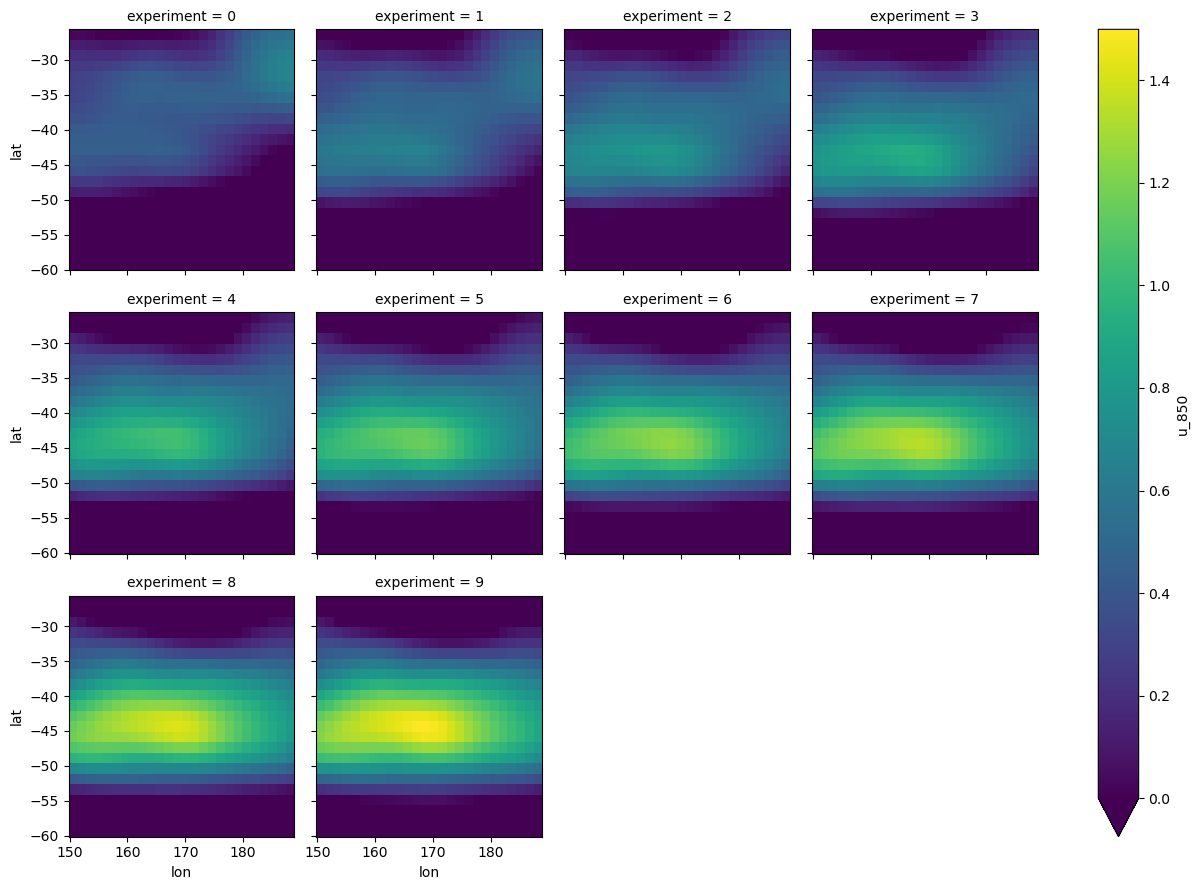

In [233]:
concat_signal.u_850.plot(col ="experiment", col_wrap =4, vmin =0)

In [22]:
concat_signal.CO2e#.isel(experiment =i)

<xarray.DataArray 'CO2e' (experiment: 10)>
array([-138.07158499,   65.4673549 ,  269.00629479,  472.54523467,
        676.08417456,  879.62311445, 1083.16205434, 1286.70099423,
       1490.23993412, 1693.778874  ])
Coordinates:
    model       int64 0
  * experiment  (experiment) int64 0 1 2 3 4 5 6 7 8 9

In [23]:
concat_signal.isel(experiment =i).drop(["CO2e","model","experiment"]) 

<xarray.Dataset>
Dimensions:  (lon: 26, lat: 23)
Coordinates:
  * lon      (lon) float64 150.6 152.1 153.6 155.1 ... 183.6 185.1 186.6 188.1
  * lat      (lat) float64 -59.38 -57.88 -56.38 -54.88 ... -29.38 -27.88 -26.38
Data variables:
    u_500    (lat, lon) float64 -1.169 -1.182 -1.197 ... -0.4429 -0.419 -0.3975
    u_850    (lat, lon) float64 -0.4181 -0.4323 -0.4479 ... -0.3004 -0.3096
    v_500    (lat, lon) float64 0.2946 0.3107 0.3223 ... 0.1327 0.1511 0.1818
    v_850    (lat, lon) float64 0.3529 0.3682 0.3706 ... 0.1417 0.1814 0.2156
    q_500    (lat, lon) float64 0.0001319 0.0001327 ... 0.0003313 0.0003351
    q_850    (lat, lon) float64 0.0005782 0.000579 ... 0.001171 0.001203
    t_500    (lat, lon) float64 2.916 2.924 2.933 2.942 ... 3.736 3.725 3.721
    t_850    (lat, lon) float64 2.629 2.63 2.638 2.646 ... 2.642 2.648 2.655

In [99]:
era5_experiments = []
for i in range(10):
    config_test_data['train_x'] = '//nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_remapped_con_v2.nc'
    stacked_Xera5, vegt, orog, he = preprocess_inference_data(config_test_data, match_index=False,experiment_data = concat_signal.isel(experiment =i).drop(["CO2e","model","experiment"]),
                                                             select_list = ['t_850','t_500','q_500','q_850','u_500','u_850','v_500','v_850'])
    era5_experiments.append(stacked_Xera5)



In [100]:
era5_experiments = xr.concat(era5_experiments, dim ="CO2_change")

In [101]:
era5_experiments = era5_experiments.to_dataset(name = "perturbed_exp")#['C02_change']

In [102]:
era5_experiments["CO2_change"] = (("CO2_change"), concat_signal.CO2e.values.ravel())

In [103]:
subset_ERA5 = era5_experiments.sel(time = slice("2023-01-01","2024-03-01"))

In [105]:
subset_ERA5.to_netcdf(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_PSW/ERA5_2023_2024_PSW_all_perturb.nc')


In [52]:

GAN_flag = True
variable = "pr"
input_data_path_base = "/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed"
gcm = "ACCESS-CM2"
ssp = "ssp370"
variant = "r4i1p1f1"
output_path_setup = "/nesi/nobackup/niwa00018/ML_Downscaled_CMIP6/"
emulator_type = "perfect_emulator"
code_dir = "/nesi/project/niwa03712/queenle/ML_emulator"

sys.path.append(f'{code_dir}/code/applying_ml_model/v3')
os.chdir(code_dir)
#try:
from src.util_functions import *
sys.path.append(f'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/')
from src.layers import *
from src.models import *
from src.gan import *

configs = {"sfcWind": "NIWA-REMS_sfcWind_v050425",
           "sfcWindmax": "NIWA-REMS_sfcWindmax_v050425",
           "tasmax": "NIWA-REMS_tasmax_v050425",
           "tasmin": "NIWA-REMS_tasmin_v050425",
           "pr": "NIWA-REMS_pr_v050425"}
variable = "pr"   
method = 'basic' # method of preprocessing input data
'''
Define config file and directories
'''
framework = "imperfect"
# define directories
ground_truth_dir = '/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/'

print('BEGINNING EMULATOR DOWNSCALING')
# Loading up the minimum value dataset
print('Variable: ' + variable + os.getcwd())
ml_model_name = configs[variable]
print(f"current path: {os.getcwd()}, code_dir: {code_dir}")
min_value = None#xr.open_dataset(r'./models/' + ml_model_name + '/min_value_outputs.nc')
model_dir ='/nesi/project/niwa03712/queenle/ML_emulator/models/'
#model_dir = './models/'
def load_model_cascade(model_name, model_dir, load_unet=True):
    gan = tf.keras.models.load_model(f'{model_dir}/{model_name}/generator_final.h5',
                                     custom_objects={"BicubicUpSampling2D": BicubicUpSampling2D,
                                                     "SymmetricPadding2D": SymmetricPadding2D},
                                     compile=False)
    with open(f'{model_dir}/{model_name}/config_info.json') as f:
        config = json.load(f)

        unet = tf.keras.models.load_model(f'{model_dir}/{model_name}/unet_final.h5',
                                          custom_objects={"BicubicUpSampling2D": BicubicUpSampling2D,
                                                          "SymmetricPadding2D": SymmetricPadding2D}, compile=False)

    return gan, unet, config["ad_loss_factor"]
#ml_model_name ='/new_model_v8_04_25_ACCESS-CM2_0.005pr_ACCESS-CM2_0.01pr_ACCESS-CM2/'
generator, unet_model, ad = load_model_cascade(ml_model_name, model_dir)


BEGINNING EMULATOR DOWNSCALING
Variable: pr/scale_wlg_persistent/filesets/project/niwa03712/queenle/ML_emulator
current path: /scale_wlg_persistent/filesets/project/niwa03712/queenle/ML_emulator, code_dir: /nesi/project/niwa03712/queenle/ML_emulator


In [53]:

@tf.function
def predict_batch_residual_v280325(model, unet, latent_vectors, data_batch, orog, he, vegt, model_type):
    if model_type =='GAN':
        intermediate =unet([data_batch, orog], training=False)
        #intermediate = apply_gaussian_blur(intermediate, size=7, sigma=1.5)
        #max_value = tf.reduce_max(intermediate, axis=(1, 2, 3), keepdims=True)
        #min_value = tf.reduce_min(intermediate, axis=(1, 2, 3), keepdims=True)
        init_prediction = intermediate#(intermediate - min_value)/(max_value - min_value)
        #print(intermediate)
        #intermediate = tf.cast(tf.math.sqrt(tf.clip_by_value(intermediate, clip_value_min=0, clip_value_max=2500)), 'float32')
        return  model([latent_vectors[0], latent_vectors[1],  data_batch, orog, init_prediction], training=False) +intermediate#+
    else:
        return unet([data_batch, orog], training=False)

def predict_parallel_resid_v280325(model, unet, inputs, output_shape, batch_size, orog_vector, he_vector, vegt_vector,
                           model_type='GAN', output_add_factor =1, varname = "pr", output_means = None, output_stds = None):
    n_iterations = inputs.shape[0] // batch_size
    remainder = inputs.shape[0] - n_iterations * batch_size

    dset = []

    with tqdm.tqdm(total=n_iterations, desc="Predicting", unit="batch") as pbar:
        for i in range(n_iterations):
            data_batch = inputs[i * batch_size: (i + 1) * batch_size]
            random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))
            random_latent_vectors2 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[1].shape[1:]))
            #random_latent_vectors1 = tf.repeat(random_latent_vectors1, repeats=batch_size, axis=0)
            orog = expand_conditional_inputs(orog_vector, batch_size)
            he = expand_conditional_inputs(he_vector, batch_size)
            vegt = expand_conditional_inputs(vegt_vector, batch_size)

            output = predict_batch_residual_v280325(model, unet, [random_latent_vectors1, random_latent_vectors2], data_batch, orog, he, vegt,
                                            model_type)
            if varname == "pr":
                dset += (np.exp(output.numpy()[:, :, :, 0]) - output_add_factor).tolist()
            elif "sfcWind" in varname:
                default_name = "sfcWind"
                dset += (output.numpy()[:, :, :, 0] * output_stds[default_name].mean().values +output_means[default_name].mean().values).tolist()
            else:    
                dset += (output.numpy()[:, :, :, 0] * output_stds[varname].mean().values +output_means[varname].mean().values).tolist()
            pbar.update(1)  # Update the progress bar

    if remainder != 0:
        random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))
        random_latent_vectors2 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[1].shape[1:]))
        #random_latent_vectors1 = tf.repeat(random_latent_vectors1, repeats=batch_size, axis=0)
        orog = expand_conditional_inputs(orog_vector, remainder)
        he = expand_conditional_inputs(he_vector, remainder)
        vegt = expand_conditional_inputs(vegt_vector, remainder)

        output = predict_batch_residual_v280325(model, unet, [random_latent_vectors1[:remainder], random_latent_vectors2[:remainder]],
                                        inputs[inputs.shape[0] - remainder:], orog, he, vegt, model_type)

        if varname == "pr":
            dset += (np.exp(output.numpy()[:, :, :, 0]) - output_add_factor).tolist()
        elif "sfcWind" in varname:
            default_name = "sfcWind"
            dset += (output.numpy()[:, :, :, 0] * output_stds[default_name].mean().values +output_means[default_name].mean().values ).tolist()
        else:    
            dset += (output.numpy()[:, :, :, 0] * output_stds[varname].mean().values +output_means[varname].mean().values).tolist()
    output_shape['pr'].values = dset

    return output_shape

In [63]:
y = y[['pr']].isel(GCM =0)


In [62]:
output_shape

<xarray.Dataset>
Dimensions:  (time: 426, GCM: 5, lat: 172, lon: 179)
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
  * GCM      (GCM) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2024-03-01
Data variables:
    pr       (time, GCM, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [92]:
subset_ERA5 = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_PSW/ERA5_2023_2024_PSW_u_perturb.nc')

In [107]:
timer_start = time.perf_counter()
mems23333 = []
for mem in range(5):
    cos2 = []
    concats2 = []
    print(mem)
    for c02 in concat_signal.CO2e.values:
        inputs_hist = subset_ERA5.sel(CO2_change=c02, time = slice("2023-01-01","2023-03-01")).perturbed_exp.transpose('time','lat','lon','channel').values
        inputs_hist_len = len(inputs_hist)
    
        #print(np.nanmean(inputs_hist, axis = (0,1,2))[-1])
        #tf.random.set_seed(i)
        output_shape = create_output(subset_ERA5.sel(CO2_change =c02, time = slice("2023-01-01","2023-03-01")), y).squeeze()
        output_shape.pr.values = output_shape.pr.values * 0.0
        preds = predict_parallel_resid_v280325(generator, unet_model,
                                inputs_hist,
                                output_shape, 64, orog.values, he.values, vegt.values,
                                model_type='GAN', output_add_factor = output_norm, varname = "pr")
        #print(preds.max())
        #print(preds.sel(time = "2023-02-13").max())
        concats2.append(preds)
        cos2.append(c02)
    concats2 = xr.concat(concats2, dim ="CO2_change")
    concats2["CO2_change"] = (("CO2_change"), cos2)
    mems23333.append(concats2)


0


Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]


1


Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]


2


Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]


3


Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]


4


Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]


In [108]:
mems8 = xr.concat(mems23333, dim ="member")

In [109]:
mems8.to_netcdf('/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_PSW/GAN/GAN_all_perturb.nc')

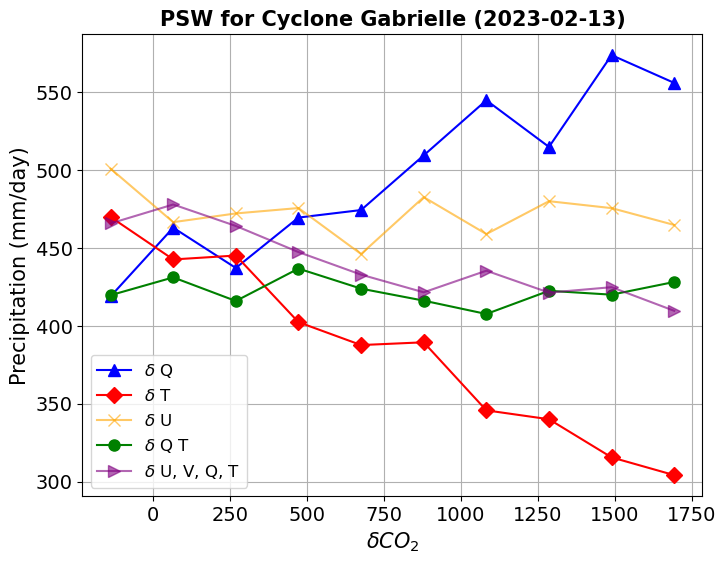

In [147]:
fig, ax = plt.subplots(1, figsize = (8, 6))
mems4.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ Q', marker = '^', color ='blue', ms = 8)
mems5.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ T', marker = 'D', color ='red', ms = 8)
mems7.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ U', marker = 'x', color ='orange', ms = 8, alpha =0.6)
mems6.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ Q T', marker = 'o', color ='green', ms = 8)
mems8.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ U, V, Q, T', marker = '>', ms = 8, color ='purple', alpha =0.6)
ax.legend(fontsize =12)
ax.set_ylabel('Precipitation (mm/day)', fontsize = 15)
ax.set_xlabel('$\delta CO_2$', weight = 'bold', fontsize = 15)
#ax.
ax.tick_params(labelsize =14)
ax.grid('on')
ax.set_title('PSW for Cyclone Gabrielle (2023-02-13)', fontsize = 15, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/Gabrielle.png', dpi =500, bbox_inches ='tight')

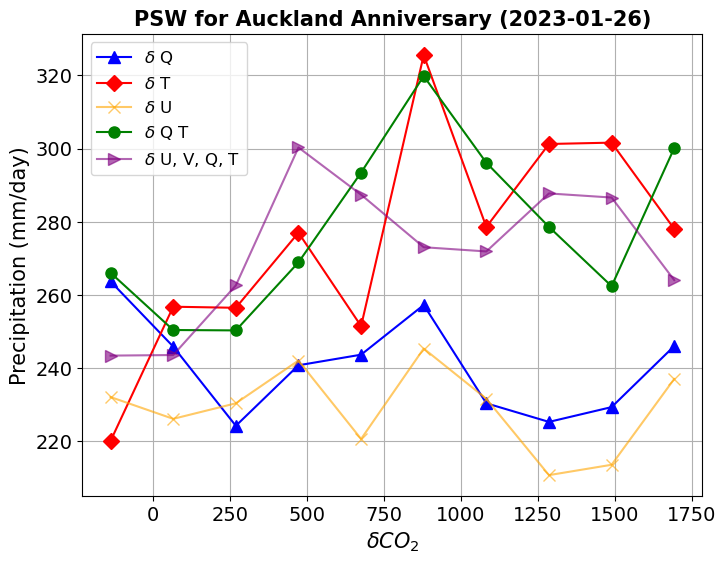

In [178]:
fig, ax = plt.subplots(1, figsize = (8, 6))
mems4.sel(time = "2023-01-26").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ Q', marker = '^', color ='blue', ms = 8)
mems5.sel(time = "2023-01-26").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ T', marker = 'D', color ='red', ms = 8)
mems7.sel(time = "2023-01-26").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ U', marker = 'x', color ='orange', ms = 8, alpha =0.6)
mems6.sel(time = "2023-01-26").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ Q T', marker = 'o', color ='green', ms = 8)
mems8.sel(time = "2023-01-26").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ U, V, Q, T', marker = '>', ms = 8, color ='purple', alpha =0.6)
ax.legend(fontsize =12)
ax.set_ylabel('Precipitation (mm/day)', fontsize = 15)
ax.set_xlabel('$\delta CO_2$', weight = 'bold', fontsize = 15)
#ax.
ax.tick_params(labelsize =14)
ax.grid('on')
ax.set_title('PSW for Auckland Anniversary (2023-01-26)', fontsize = 15, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/Anniversary.png', dpi =500, bbox_inches ='tight')

In [183]:
orog

<xarray.DataArray 'orog' (lat: 172, lon: 179)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86

Text(0.5, 1.0, 'Area-averaged Max Precip \n PSW (1 Jan - 1 March 2023)')

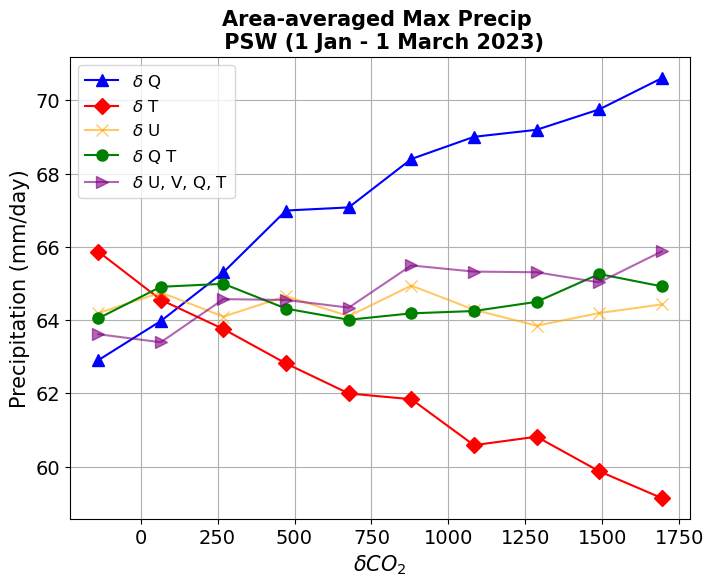

In [185]:
fig, ax = plt.subplots(1, figsize = (8, 6))
mems4.max(["time"]).max("member").mean(["lat","lon"]).pr.plot(ax = ax, label ='$\delta$ Q', marker = '^', color ='blue', ms = 8)
mems5.max(["time"]).max("member").mean(["lat","lon"]).pr.plot(ax = ax, label ='$\delta$ T', marker = 'D', color ='red', ms = 8)
mems7.max(["time"]).max("member").mean(["lat","lon"]).pr.plot(ax = ax, label ='$\delta$ U', marker = 'x', color ='orange', ms = 8, alpha =0.6)
mems6.max(["time"]).max("member").mean(["lat","lon"]).pr.plot(ax = ax, label ='$\delta$ Q T', marker = 'o', color ='green', ms = 8)
mems8.max(["time"]).max("member").mean(["lat","lon"]).pr.plot(ax = ax, label ='$\delta$ U, V, Q, T', marker = '>', ms = 8, color ='purple', alpha =0.6)
ax.legend(fontsize =12)
ax.set_ylabel('Precipitation (mm/day)', fontsize = 15)
ax.set_xlabel('$\delta CO_2$', weight = 'bold', fontsize = 15)
#ax.
ax.tick_params(labelsize =14)
ax.grid('on')
ax.set_title('Area-averaged Max Precip \n PSW (1 Jan - 1 March 2023)', fontsize = 15, weight ='bold')
#fig.savefig(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/Anniversary.png', dpi =500, bbox_inches ='tight')

/tmp/ipykernel_12563/645664759.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


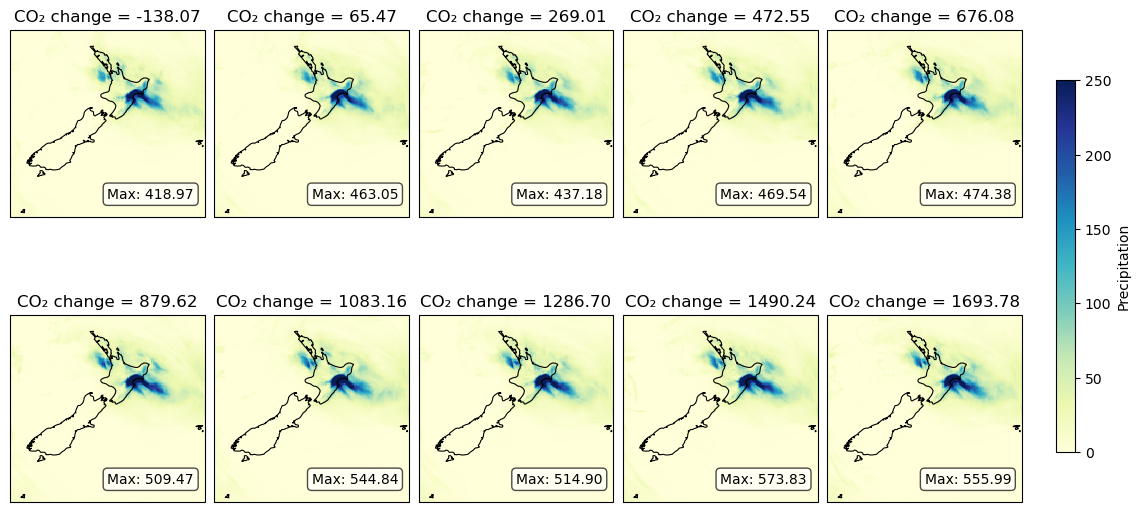

In [176]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Take the data
ds = mems4.sel(time="2023-02-13").max("member")

# How many CO2_change slices?
n = ds.CO2_change.size

# Create subplots (adjust columns/rows as you like)
fig, axes = plt.subplots(
    2, n//2,  # 1 row, n columns
    figsize=(12, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude =171.77)}
)
axes = axes.ravel()
# If there's only one axis, make it iterable
if n == 1:
    axes = [axes]

# Loop over each CO2_change and corresponding axis
for i, co2_val in enumerate(ds.CO2_change.values):
    ax = axes[i]
    data_slice = ds.sel(CO2_change=co2_val).pr

    # Compute max precip for this slice
    max_precip = float(data_slice.max())

    # Plot
    im = data_slice.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="YlGnBu",
        robust=True,
        add_colorbar=False, vmax =250, vmin =0  # one shared colorbar later if needed
    )

    # Add coastlines and borders
    ax.coastlines(resolution="50m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # Annotate max precip
    ax.text(
        0.5, 0.1,
        f"Max: {max_precip:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    ax.set_title(f"CO₂ change = {'%.2f' % co2_val}")

# Optional: add one colorbar for all
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=-0.19)
cbar.set_label("Precipitation")

plt.tight_layout()
plt.show()
fig.savefig(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/max_precip_iten.png', dpi =500, bbox_inches ='tight')

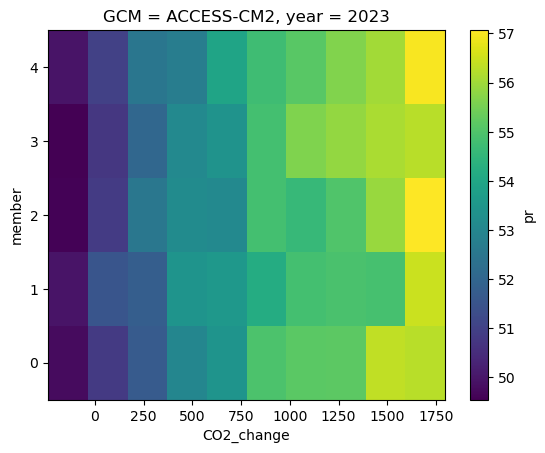

In [186]:
mems4.groupby('time.year').max().isel(year =0).mean(["lat","lon"]).squeeze().pr.plot()

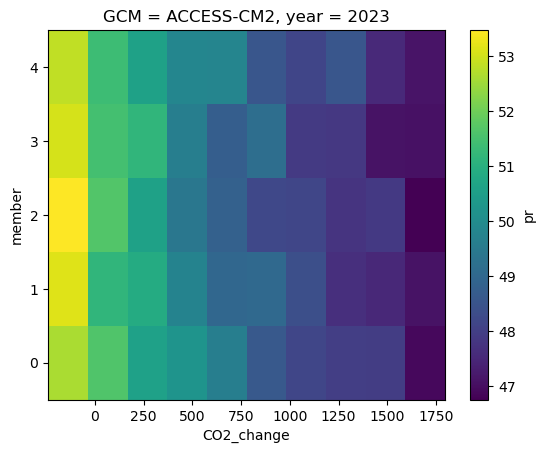

In [187]:
mems5.groupby('time.year').max().isel(year =0).mean(["lat","lon"]).squeeze().pr.plot()

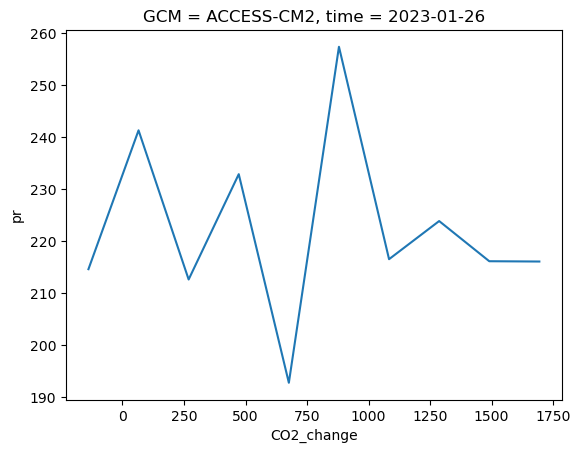

In [188]:
mems4.sel(member =0, time ="2023-01-26").pr.max(["lat","lon"]).plot()

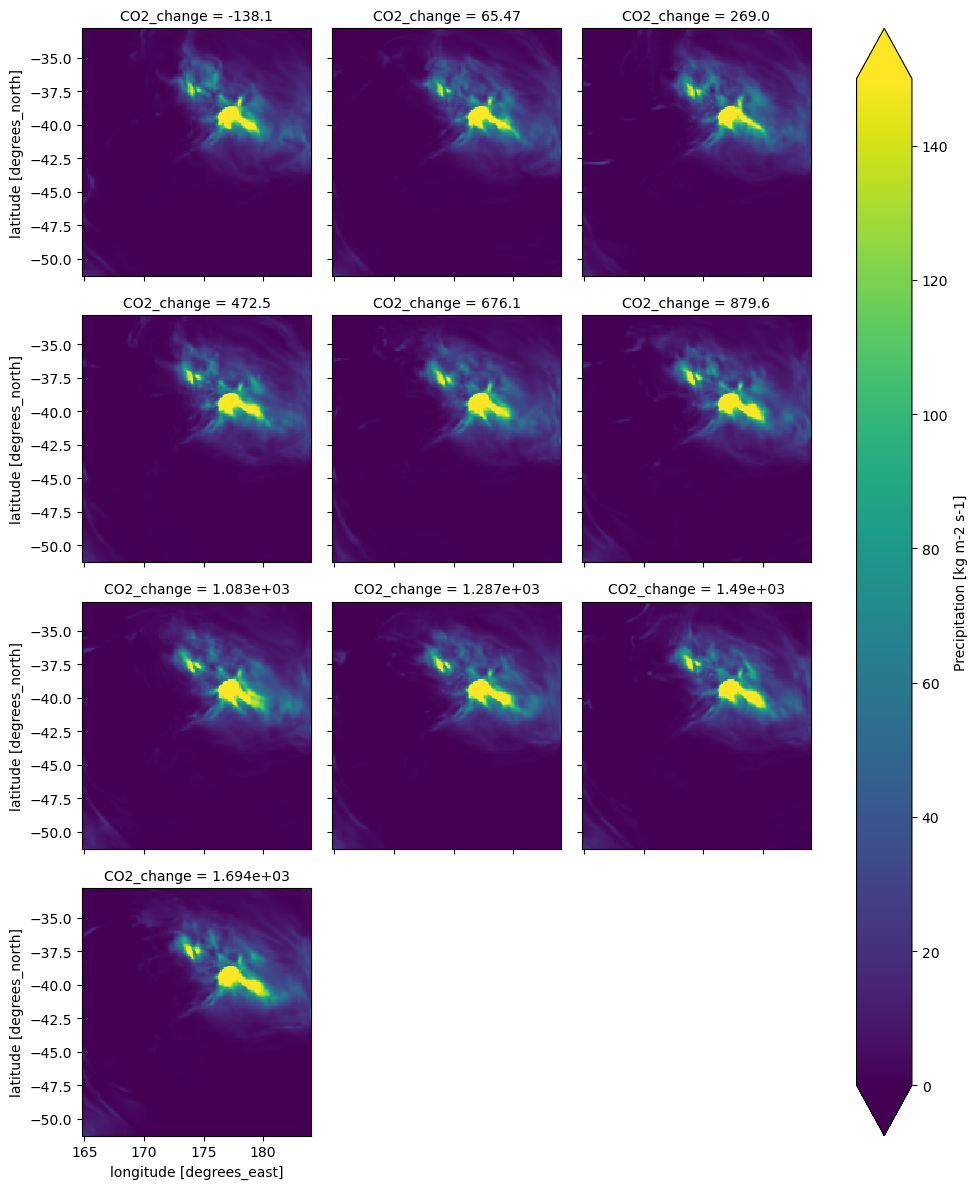

In [189]:
mems4.sel(member =0, time ="2023-02-13").pr.plot(col = "CO2_change", col_wrap =3, vmin =0, cmap ='viridis', vmax =150)

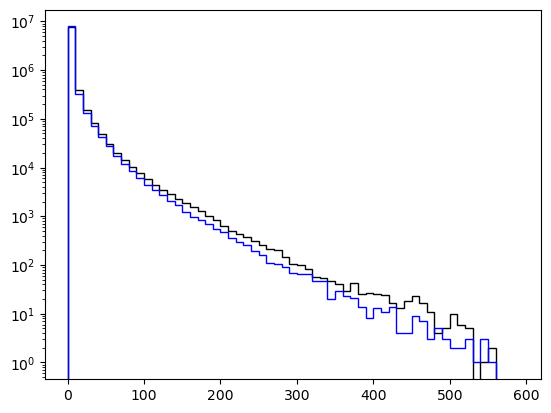

In [193]:
fig, ax = plt.subplots()
ax.hist(mems4.isel(CO2_change =-1).pr.values.ravel(), bins = np.arange(0, 600, 10), histtype ='step', color ='k')
ax.hist(mems4.isel(CO2_change =0).pr.values.ravel(), bins = np.arange(0, 600, 10), histtype ='step', color ='b')
ax.set_yscale('log')

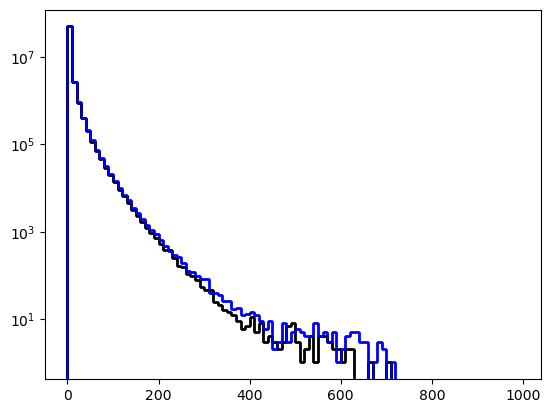

In [1473]:
fig, ax = plt.subplots()
for i in range(10):
    ax.hist(mems3.isel(CO2_change =2).pr.values.ravel(), bins = np.arange(0, 1000, 10), histtype ='step', color ='k')
    ax.hist(mems3.isel(CO2_change =-1).pr.values.ravel(), bins = np.arange(0, 1000, 10), histtype ='step', color ='b')
ax.set_yscale('log')

In [1728]:
mems_qunatiles = mems4.where(mems4>0, np.nan).quantile(q = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.925,0.95, 0.975,0.99, 0.995, 0.999, 0.9999], dim =["time","member"], skipna=True)

In [1729]:
mems_qunatiles_signal = 100 * (mems_qunatiles - mems_qunatiles.isel(CO2_change =0))/mems_qunatiles.isel(CO2_change =0)


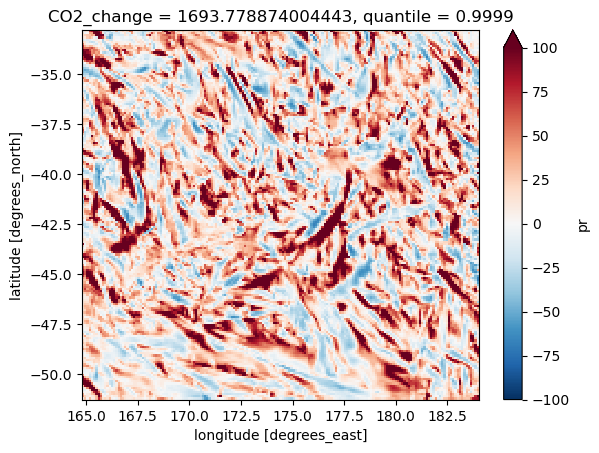

In [1737]:
mems_qunatiles_signal.isel(quantile =-1, CO2_change =-1).pr.plot(vmax =100)

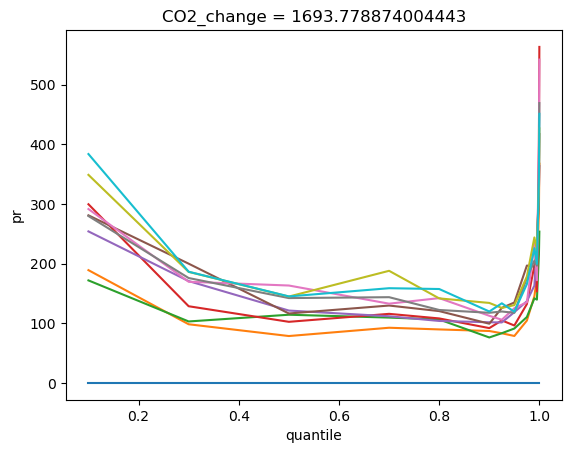

In [1738]:
fig, ax = plt.subplots()
for i in range(10):
    mems_qunatiles_signal.max(["lat","lon"]).isel(CO2_change =i).pr.plot(ax=ax)
    

In [1671]:
era5_experiments

<xarray.Dataset>
Dimensions:        (time: 1917, lon: 26, lat: 23, channel: 8, CO2_change: 10)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2025-03-31
  * lon            (lon) float64 150.6 152.1 153.6 155.1 ... 185.1 186.6 188.1
  * lat            (lat) float64 -59.38 -57.88 -56.38 ... -29.38 -27.88 -26.38
  * channel        (channel) <U5 'q_500' 'q_850' 'u_500' ... 't_500' 't_850'
  * CO2_change     (CO2_change) float64 -138.1 65.47 ... 1.49e+03 1.694e+03
Data variables:
    perturbed_exp  (CO2_change, channel, time, lat, lon) float64 -0.8919 ... ...

In [1739]:
subset_ERA5 = era5_experiments.sel(time = slice("2023-01-25","2023-02-15"))

In [202]:
subset_ERA5 = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_PSW/ERA5_2023_2024_PSW_t_perturb.nc')

In [203]:
subset_ERA5 = era5_experiments.sel(time = slice("2023-01-01","2023-03-01"))

In [209]:
timer_start = time.perf_counter()
mems = []
for mem in range(2):
    cos2 = []
    concats = []
    for c02 in concat_signal.CO2e.values:
        inputs_hist = subset_ERA5.sel(CO2_change=c02).perturbed_exp.transpose('time','lat','lon','channel').values
        inputs_hist_len = len(inputs_hist)
        #print(np.nanmean(inputs_hist, axis = (0,1,2))[-1])
        #tf.random.set_seed(i)
        output_shape = create_output(subset_ERA5.sel(CO2_change =c02), y).squeeze()
        output_shape.pr.values = output_shape.pr.values * 0.0
        preds = predict_parallel_resid(dm, unet,
                                inputs_hist,
                                output_shape, 31, orog.values, he.values, vegt.values,
                                model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler)
        #print(preds.max())
        concats.append(preds)
        cos2.append(c02)
    concats = xr.concat(concats, dim ="CO2_change")
    concats["CO2_change"] = (("CO2_change"), cos2)
    mems.append(concats)


Predicting: 100%|██████████| 1/1 [00:15<00:00, 15.92s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.50s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)



Predicting: 100%|██████████| 1/1 [00:11<00:00, 11.51s/batch]

(31, 172, 179, 1)


In [210]:
mems2 = xr.concat(mems, dim ="member")

In [211]:
mems2.to_netcdf('/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/ERA5_PSW/diffusion/diffusion_q_perturb.nc')

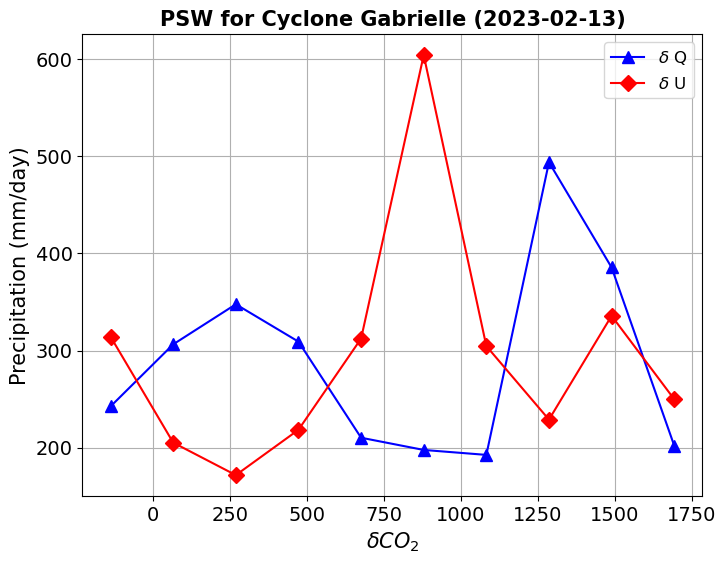

In [212]:
fig, ax = plt.subplots(1, figsize = (8, 6))
mems2.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ Q', marker = '^', color ='blue', ms = 8)
mems1.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ U', marker = 'D', color ='red', ms = 8)
#mems7.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ U', marker = 'x', color ='orange', ms = 8, alpha =0.6)
#mems6.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ Q T', marker = 'o', color ='green', ms = 8)
#mems8.sel(time = "2023-02-13").max(["lat","lon"]).max("member").pr.plot(ax = ax, label ='$\delta$ U, V, Q, T', marker = '>', ms = 8, color ='purple', alpha =0.6)
ax.legend(fontsize =12)
ax.set_ylabel('Precipitation (mm/day)', fontsize = 15)
ax.set_xlabel('$\delta CO_2$', weight = 'bold', fontsize = 15)
#ax.
ax.tick_params(labelsize =14)
ax.grid('on')
ax.set_title('PSW for Cyclone Gabrielle (2023-02-13)', fontsize = 15, weight ='bold')
fig.savefig(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/Gabrielle_diffusion.png', dpi =500, bbox_inches ='tight')

/tmp/ipykernel_12563/3746030795.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


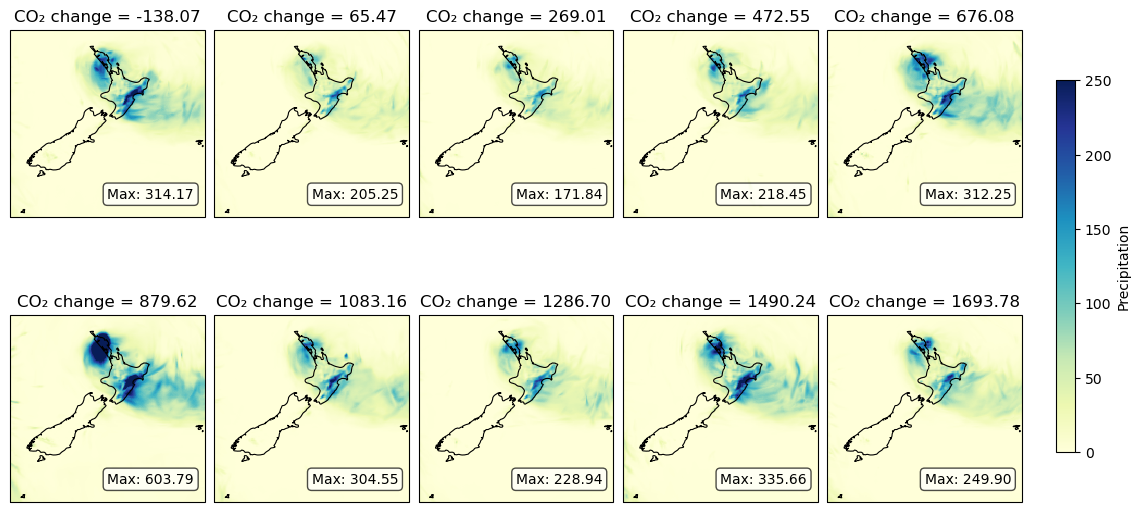

In [206]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Take the data
ds = mems1.sel(time="2023-02-13").max("member")

# How many CO2_change slices?
n = ds.CO2_change.size

# Create subplots (adjust columns/rows as you like)
fig, axes = plt.subplots(
    2, n//2,  # 1 row, n columns
    figsize=(12, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude =171.77)}
)
axes = axes.ravel()
# If there's only one axis, make it iterable
if n == 1:
    axes = [axes]

# Loop over each CO2_change and corresponding axis
for i, co2_val in enumerate(ds.CO2_change.values):
    ax = axes[i]
    data_slice = ds.sel(CO2_change=co2_val).pr

    # Compute max precip for this slice
    max_precip = float(data_slice.max())

    # Plot
    im = data_slice.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="YlGnBu",
        robust=True,
        add_colorbar=False, vmax =250, vmin =0  # one shared colorbar later if needed
    )

    # Add coastlines and borders
    ax.coastlines(resolution="50m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # Annotate max precip
    ax.text(
        0.5, 0.1,
        f"Max: {max_precip:.2f}",
        transform=ax.transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
    )

    ax.set_title(f"CO₂ change = {'%.2f' % co2_val}")

# Optional: add one colorbar for all
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=-0.19)
cbar.set_label("Precipitation")

plt.tight_layout()
plt.show()
fig.savefig(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/GCM_emulator/figures/max_precip_iten_diffusion_u_perturb.png', dpi =500, bbox_inches ='tight')

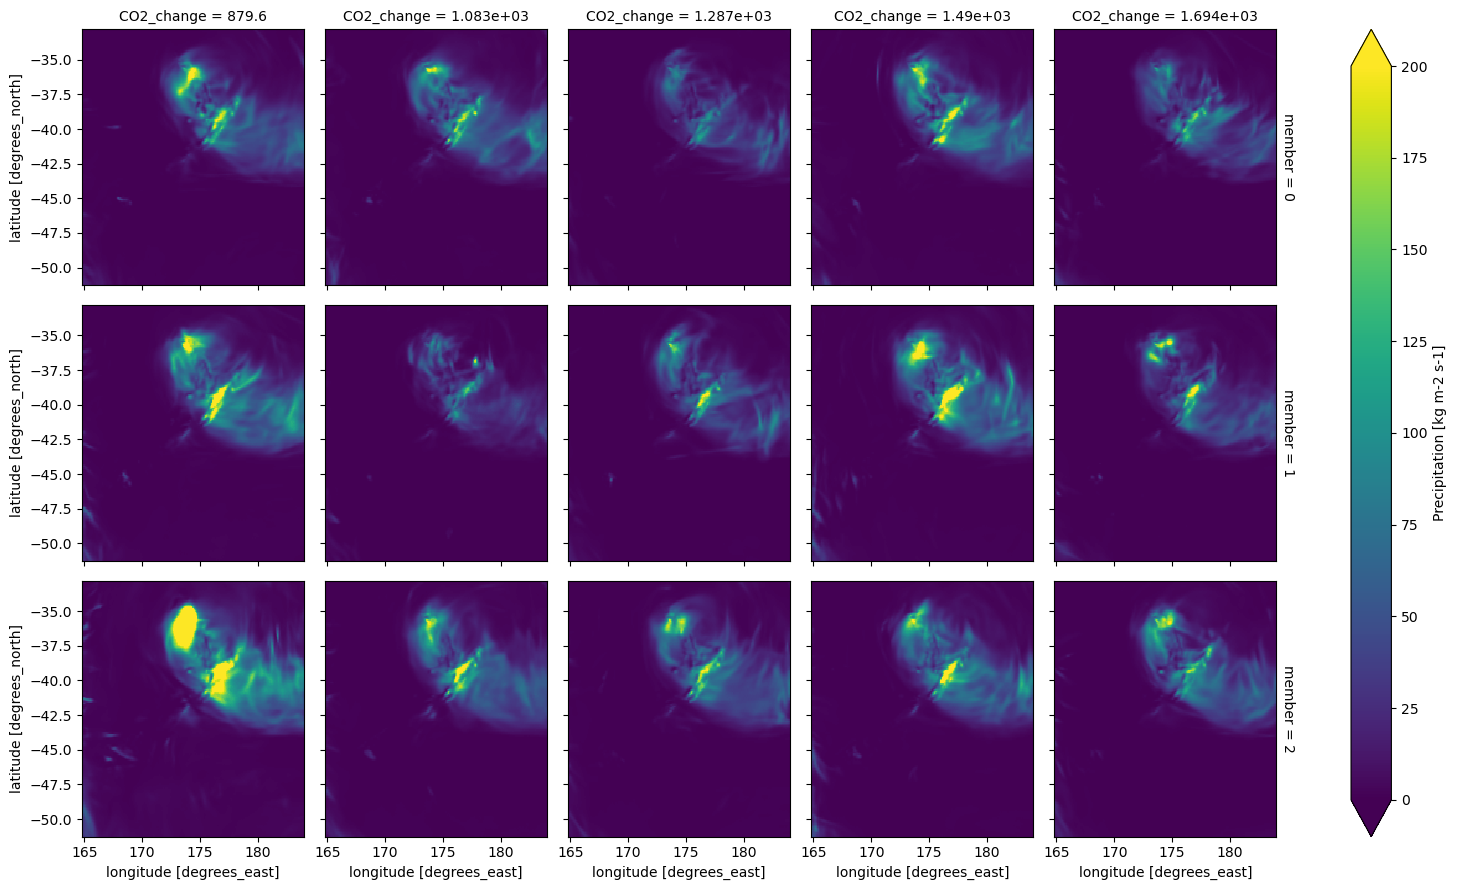

In [207]:
mems1.pr.sel(time = "2023-02-13").isel(CO2_change = slice(-5, None)).plot(col = "CO2_change", row = "member", vmin =0, vmax =200)

In [1351]:
mems3['C02_change'] = cos2

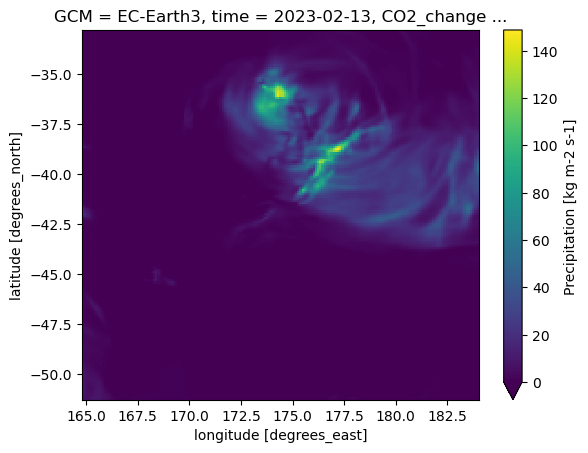

In [1763]:
mems1.pr.isel(member =0, CO2_change=-8, time =19).plot(vmin =0)

Text(0.5, 0, '$\\delta C0_{2} (ppm)$')

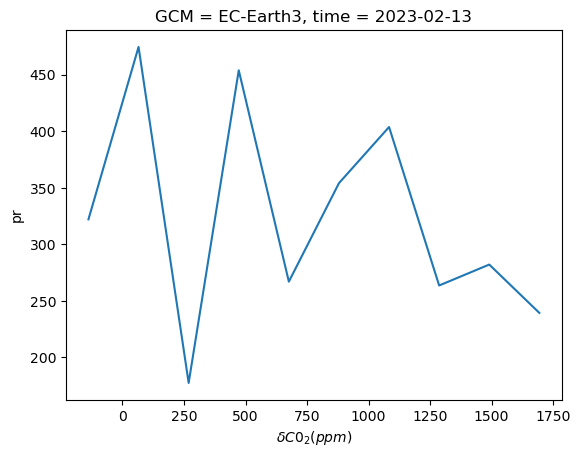

In [1747]:
fig, ax = plt.subplots()
mems1.pr.sel(time = "2023-02-13").max(["lat","lon"]).max("member").plot()
#plt.xscale('log')
ax.set_xlabel('$\delta C0_{2} (ppm)$')

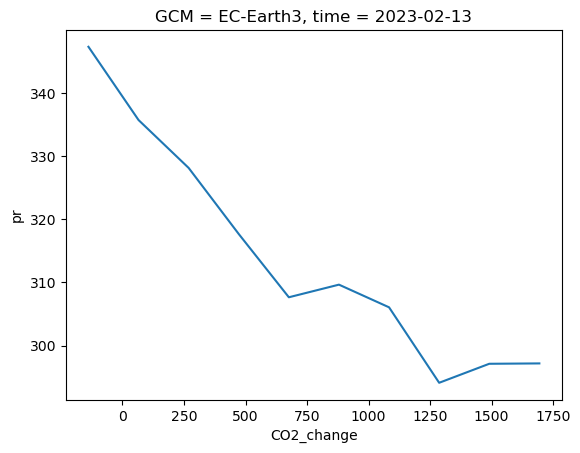

In [1370]:
mems3.pr.sel(time = "2023-02-13").max(["lat","lon"]).mean("member").plot()
#mems3.pr.sel(time = "2023-02-13").max(["lat","lon"]).mean("member").plot()

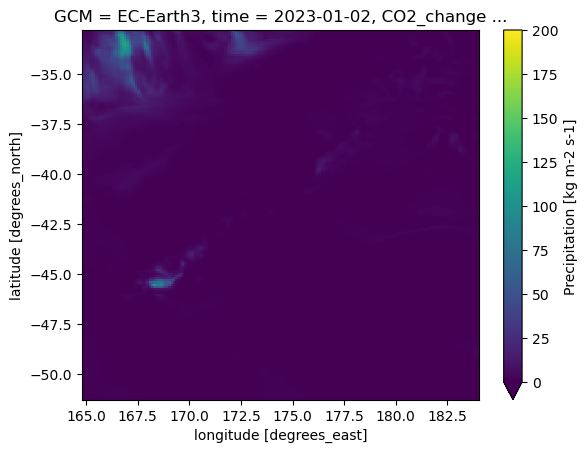

In [1684]:
mems3.pr.isel(member =0, CO2_change=3, time =1).plot(vmin =0, vmax =200)

In [ ]:
mem

In [1128]:

# output_hist_unet = predict_parallel_resid(dm, unet,
#                             inputs_hist,
#                             output_shape.sel(time = historical_period), 32, orog.values, he.values, vegt.values,
#                             model_type='UNet', output_add_factor = output_norm, scheduler=scheduler)
timer_stop = time.perf_counter()
timer_elapsed = timer_stop - timer_start
print(f"Historical period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")

Historical period - diffusion - elapsed: 81.383369 s (16.276674 s/it, 5 it)


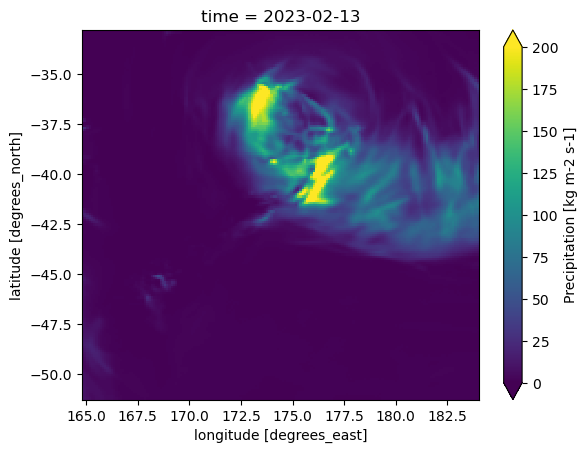

In [1172]:
concats.pr.sel(time = "2023-02-13").isel(C02_change =-3).drop("GCM").plot( vmin =0, col_wrap =3,vmax =200, cmap = 'viridis')

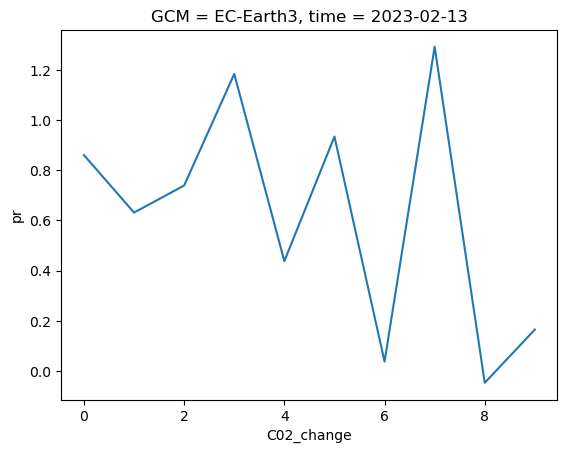

In [1139]:
concats.sel(time = "2023-02-13").pr.median(["lat","lon"]).plot()

In [1008]:

inputs_hist = subset_ERA5.transpose('time','latitude','longitude','channel').values
inputs_hist_len = len(inputs_hist)

#     output_hist_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_hist_bwar780.nc'
#     if not os.path.exists(output_hist_path):
timer_start = time.perf_counter()
concats = []
for i in range(2):
    
    tf.random.set_seed(i)
    preds = predict_parallel_resid(dm, unet,
                            inputs_hist,
                            output_shape, 32, orog.values, he.values, vegt.values,
                            model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler)
    concats.append(preds)
concats = xr.concat(concats, dim ="member")
# output_hist_unet = predict_parallel_resid(dm, unet,
#                             inputs_hist,
#                             output_shape.sel(time = historical_period), 32, orog.values, he.values, vegt.values,
#                             model_type='UNet', output_add_factor = output_norm, scheduler=scheduler)
timer_stop = time.perf_counter()
timer_elapsed = timer_stop - timer_start
print(f"Historical period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")


Predicting: 0batch [00:00, ?batch/s]
Predicting: 0batch [00:00, ?batch/s]


Historical period - diffusion - elapsed: 7.981380 s (2.660460 s/it, 3 it)


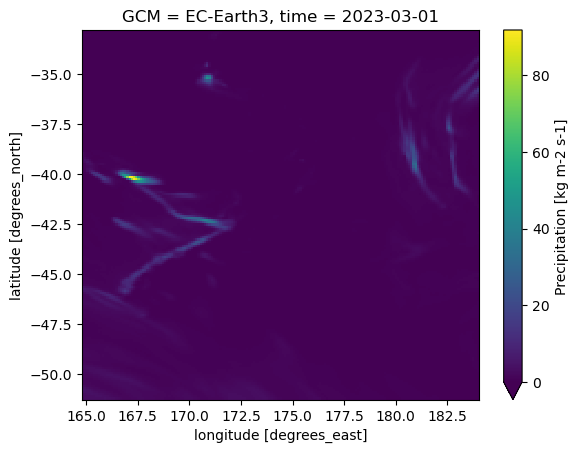

In [1007]:
concats.isel(member =1, time =0).pr.plot(vmin =0)

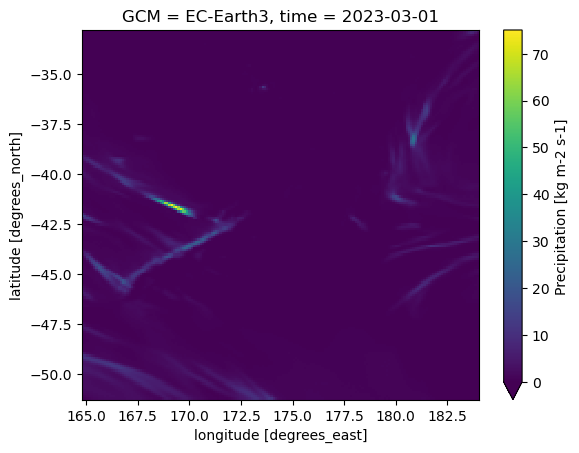

In [1009]:
concats.isel(member =1, time =0).pr.plot(vmin =0)

In [966]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import numpy as np

# Define a custom colormap: white (low) → blue → orange → purple (high)
colors = ["#ffffff", "#1f78b4", "#ff7f00", "#6a0dad"]  # white, blue, orange, purple
cmap = mcolors.LinearSegmentedColormap.from_list("white_blue_orange_purple", colors)


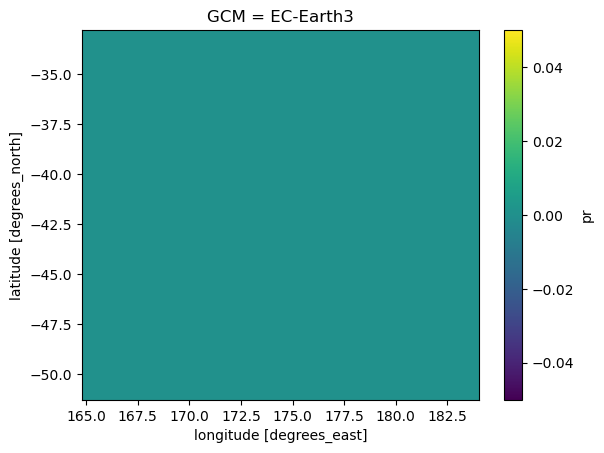

In [998]:
(concats.isel(member =1).sum("time") - concats.isel(member =0).sum("time")).pr.plot()

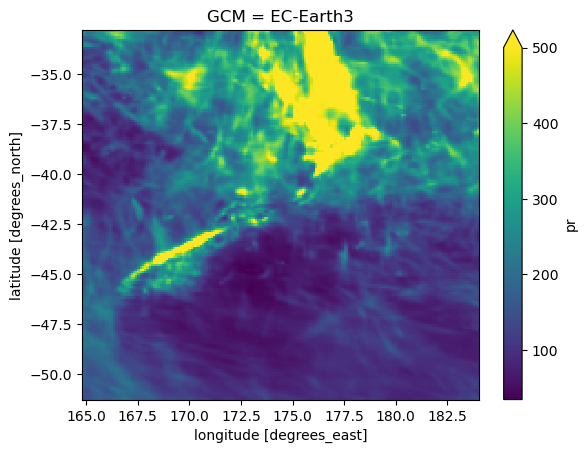

In [990]:
concats.isel(member =1).sum("time").pr.plot(vmax =500)

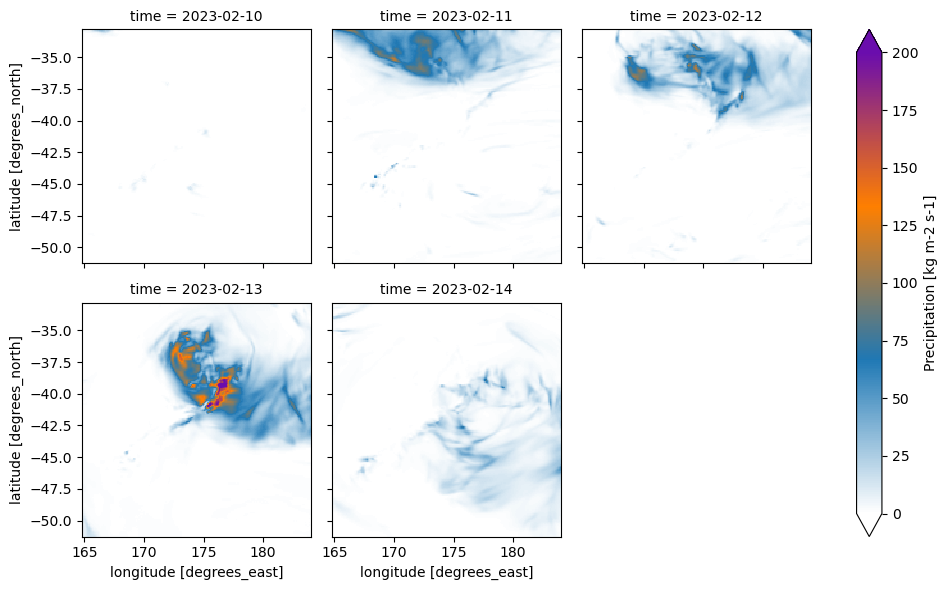

In [979]:
output_hist4.isel(member =0).sel(time = slice("2023-02-10","2023-02-14")).pr.plot(col ="time", cmap = cmap,vmin =0, vmax =200, col_wrap =3)

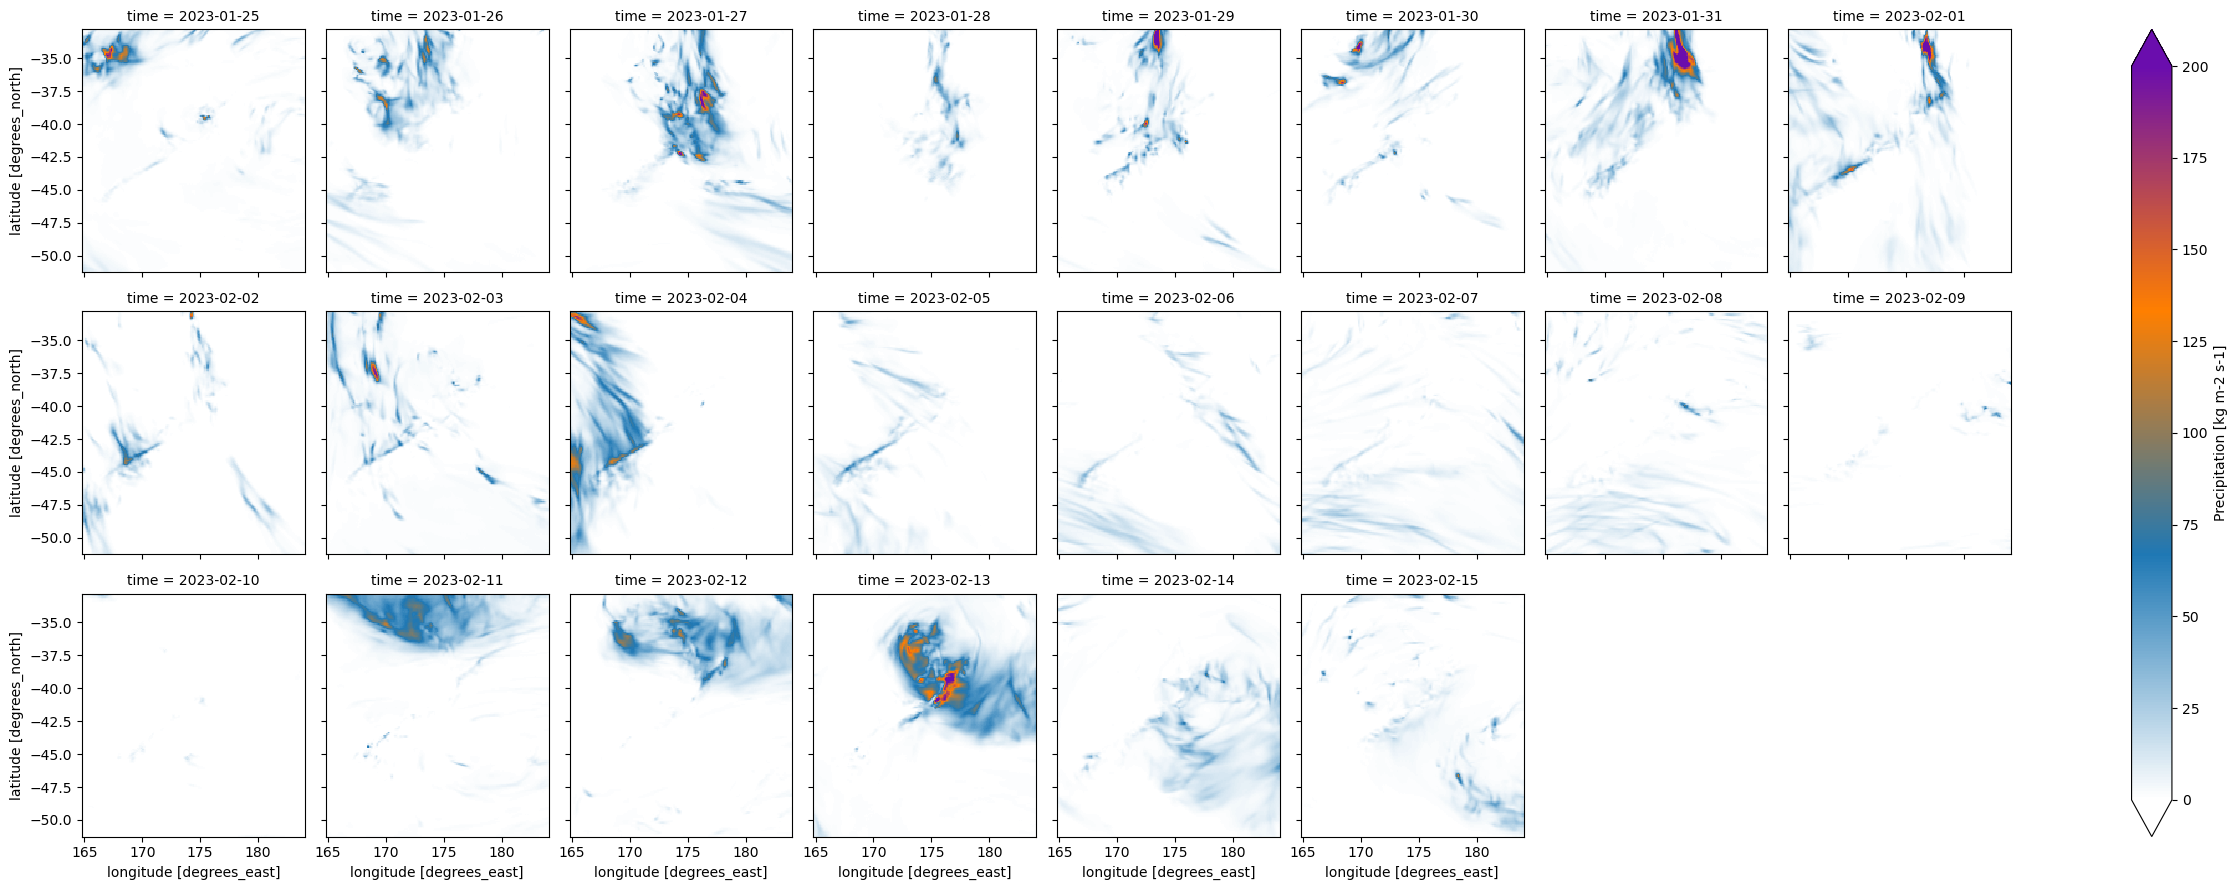

In [1176]:
output_hist4.isel(member =0).sel(time = slice("2023-01-25","2023-02-15")).pr.plot(col ="time", cmap = cmap,vmin =0, vmax =200, col_wrap =8)

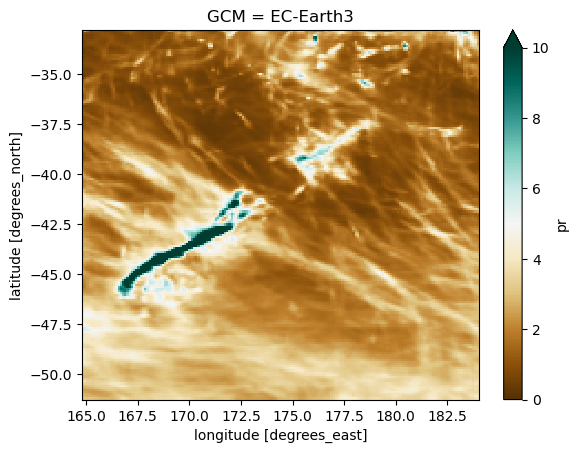

In [774]:
output_hist4.mean("time").pr.plot(vmin =0, vmax =10, cmap ='BrBG')

In [648]:
(40 * 6) * 100/3600

6.666666666666667

In [455]:
# 6 minutes per year?

3200

In [588]:
timer_start = time.perf_counter()
output_hist_unet = predict_parallel_resid(dm, unet,
                            inputs_hist,
                            output_shape.sel(time = historical_period), 32, orog.values, he.values, vegt.values,
                            model_type='UNet', output_add_factor = output_norm, scheduler=scheduler)
timer_stop = time.perf_counter()
timer_elapsed = timer_stop - timer_start
print(f"Historical period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")


Predicting:   0%|          | 0/11 [00:00<?, ?batch/s]

(32, 172, 179, 1)


Predicting:   9%|▉         | 1/11 [00:00<00:03,  3.06batch/s]

(32, 172, 179, 1)


Predicting:  18%|█▊        | 2/11 [00:00<00:02,  3.00batch/s]

(32, 172, 179, 1)


Predicting:  27%|██▋       | 3/11 [00:00<00:02,  3.05batch/s]

(32, 172, 179, 1)


Predicting:  36%|███▋      | 4/11 [00:01<00:02,  3.02batch/s]

(32, 172, 179, 1)


Predicting:  45%|████▌     | 5/11 [00:01<00:01,  3.00batch/s]

(32, 172, 179, 1)


Predicting:  55%|█████▍    | 6/11 [00:01<00:01,  3.04batch/s]

(32, 172, 179, 1)


Predicting:  64%|██████▎   | 7/11 [00:02<00:01,  3.02batch/s]

(32, 172, 179, 1)


Predicting:  73%|███████▎  | 8/11 [00:02<00:00,  3.01batch/s]

(32, 172, 179, 1)


Predicting:  82%|████████▏ | 9/11 [00:02<00:00,  3.05batch/s]

(32, 172, 179, 1)


Predicting:  91%|█████████ | 10/11 [00:03<00:00,  3.03batch/s]

(32, 172, 179, 1)


Predicting: 100%|██████████| 11/11 [00:03<00:00,  3.03batch/s]


Historical period - diffusion - elapsed: 5.381080 s (0.014662 s/it, 367 it)


In [590]:
output_hist

<xarray.Dataset>
Dimensions:  (time: 367, lat: 172, lon: 179)
Coordinates:
  * lon      (lon) float32 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
  * lat      (lat) float32 -51.21 -51.11 -51.0 -50.89 ... -33.07 -32.97 -32.86
    GCM      <U10 'ACCESS-CM2'
  * time     (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2005-01-01
Data variables:
    pr       (time, lat, lon) float64 -0.1336 -0.1715 -0.1553 ... 0.4532 0.2343
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.co.nz)
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

In [716]:
output_hist2.max()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    GCM      <U9 'EC-Earth3'
Data variables:
    pr       float64 552.9

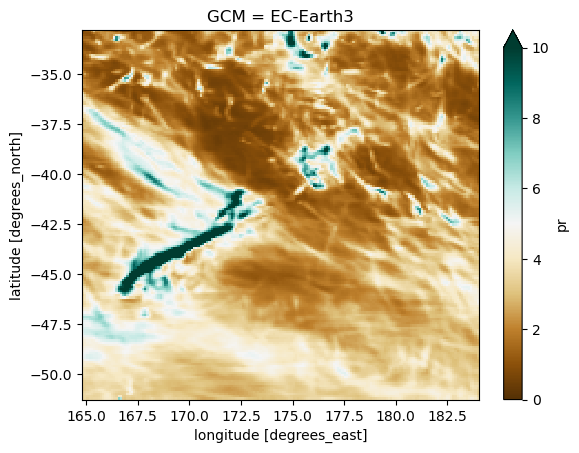

In [717]:
output_hist2.pr.mean('time').plot(vmin =0, vmax =10, cmap ='BrBG')

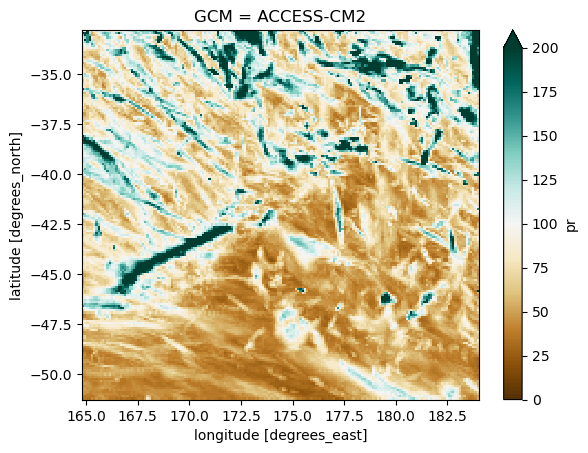

In [602]:
output_hist.pr.max('time').plot(vmin =0, vmax =200, cmap ='BrBG')

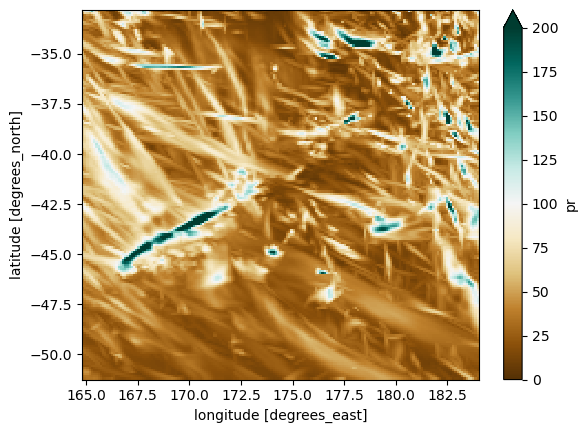

In [627]:
(df.pr.sel(time = slice("2004","2004-03-01")).max("time")*86400).plot(vmin =0, vmax =200, cmap ='BrBG')

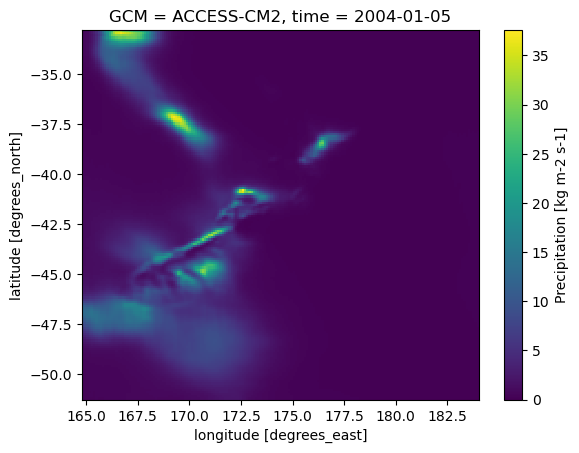

In [398]:
output_hist_unet.pr.isel(time =4).plot(vmin =0)

In [668]:
df = xr.open_dataset(r'/nesi/project/niwa00018/rampaln/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/EC-Earth3_hist_ssp370_pr_psl_tasmin_tasmax_sfcwind_sfcwindmax.nc')

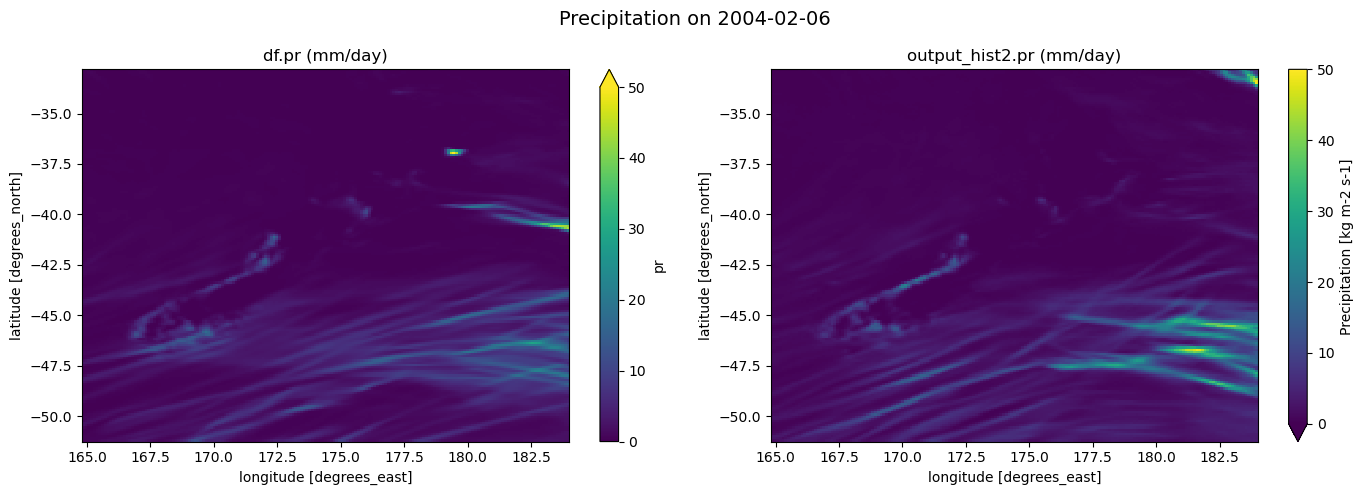

In [731]:
import matplotlib.pyplot as plt

# Select and convert to mm/day
pr1 = df.pr.sel(time="2004-02-12") * 86400
pr2 = output_hist2.pr.sel(time="2004-02-12")

# Determine common vmin/vmax for consistent scale
vmin = 0
vmax = 50#max(pr1.max().item(), pr2.max().item())  # or set manually, e.g., 100

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cmap = 'viridis'#"gist_ncar"  # Try 'cubehelix_r', 'PuBuGn', or 'jet' as alternatives
# Plot first
pr1.plot(ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax)
axes[0].set_title("df.pr (mm/day)")

# Plot second
pr2.plot(ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title("output_hist2.pr (mm/day)")

# Overall title
plt.suptitle("Precipitation on 2004-02-06", fontsize=14)

plt.tight_layout()
plt.show()



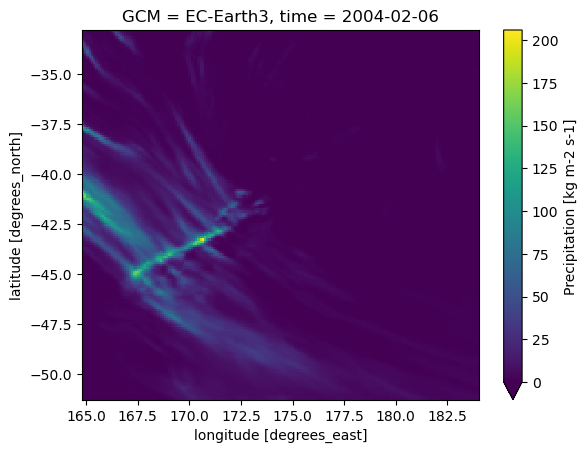

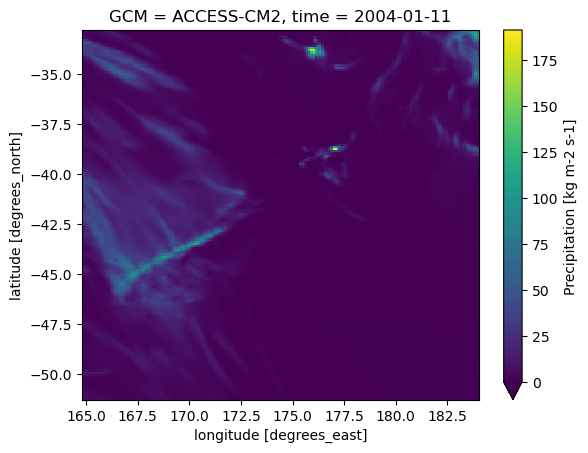

In [337]:
output_hist_unet.pr.isel(time =8).plot(vmin =0)

In [326]:
output_hist_unet.pr.isel(time =8).plot(vmin =0)

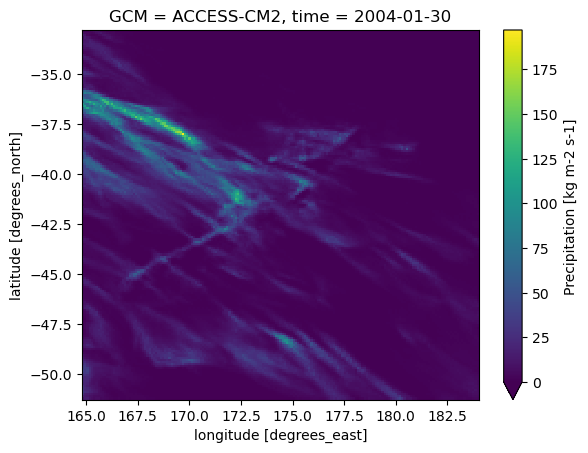

In [198]:
output_hist.pr.isel(time =29).plot(vmin =0)

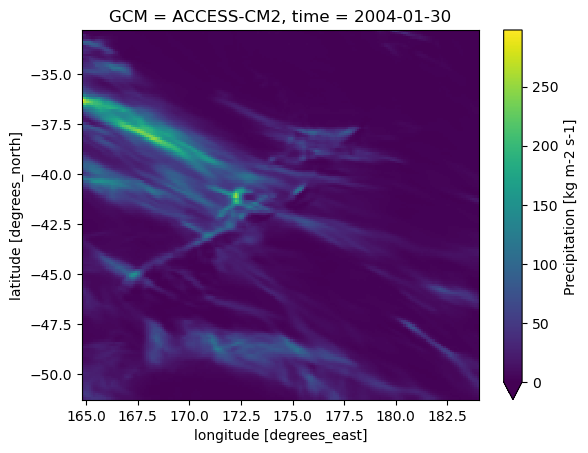

In [185]:
output_hist.pr.isel(time =29).plot(vmin =0)

In [178]:
output_hist.pr.isel(time =29).plot(vmax =100, vmin =0)

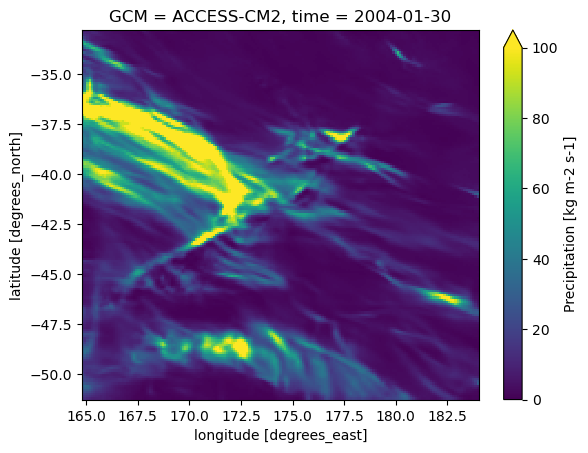

In [143]:
output_hist.pr.isel(time =29).plot(vmax =100, vmin =0)

In [ ]:
        output_hist.to_netcdf(output_hist_path)
        del output_hist
    else:
        print(f"Historical period - {generator_model_type} - skipped (netcdf file already exists)")


    output_hist_unet_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_hist_bwar780.nc'
    if not os.path.exists(output_hist_unet_path):
        timer_start = time.perf_counter()
        output_hist_unet = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_hist,
                                    output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
                                    model_type='UNET', output_add_factor = output_norm) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Historical period - unet only - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")

        output_hist_unet.to_netcdf(output_hist_unet_path)
        del output_hist_unet
    else:
        print("Historical period - unet only - skipped (netcdf file already exists)")

    del inputs_hist

    inputs_future = stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = future_period).values
    inputs_future_len = len(inputs_future)


    output_future_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_future_bwar780.nc'
    if not os.path.exists(output_future_path):
        timer_start = time.perf_counter()
        output_future = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_future,
                                    output_shape.sel(time = future_period), 64, orog.values, he.values, vegt.values,
                                    model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Future period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_future_len:.6f} s/it, {inputs_future_len} it)")

        output_future.to_netcdf(output_future_path)
        del output_future
    else:
        print(f"Future period - {generator_model_type} - skipped (netcdf file already exists)")


    output_future_unet_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_future_bwar780.nc'
    if not os.path.exists(output_future_unet_path):
        timer_start = time.perf_counter()
        output_future_unet = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_future,
                                    output_shape.sel(time = future_period), 64, orog.values, he.values, vegt.values,
                                    model_type='UNET', output_add_factor = output_norm) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Future period - unet only - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_future_len:.6f} s/it, {inputs_future_len} it)")

        output_future_unet.to_netcdf(output_future_unet_path)
        del output_future_unet
    else:
        print("Future period - unet only - skipped (netcdf file already exists)")

    del inputs_future

In [ ]:










    print(f"preparing data for a GCM {gcm}")

    if not os.path.exists(f'./outputs/{config["model_name"]}'):
        os.makedirs(f'./outputs/{config["model_name"]}')

    with open(f'./outputs/{config["model_name"]}/config_info.json', 'w') as f:
        json.dump(config, f)

    output_shape = create_output(stacked_X, y)
    output_shape.pr.values = output_shape.pr.values * 0.0
    
    inputs_hist = stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values
    inputs_hist_len = len(inputs_hist)

    output_hist_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_hist_bwar780.nc'
    if not os.path.exists(output_hist_path):
        timer_start = time.perf_counter()
        output_hist = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_hist,
                                    output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
                                    model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Historical period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")

        output_hist.to_netcdf(output_hist_path)
        del output_hist
    else:
        print(f"Historical period - {generator_model_type} - skipped (netcdf file already exists)")


    output_hist_unet_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_hist_bwar780.nc'
    if not os.path.exists(output_hist_unet_path):
        timer_start = time.perf_counter()
        output_hist_unet = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_hist,
                                    output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
                                    model_type='UNET', output_add_factor = output_norm) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Historical period - unet only - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_hist_len:.6f} s/it, {inputs_hist_len} it)")

        output_hist_unet.to_netcdf(output_hist_unet_path)
        del output_hist_unet
    else:
        print("Historical period - unet only - skipped (netcdf file already exists)")

    del inputs_hist

    inputs_future = stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = future_period).values
    inputs_future_len = len(inputs_future)


    output_future_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_future_bwar780.nc'
    if not os.path.exists(output_future_path):
        timer_start = time.perf_counter()
        output_future = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_future,
                                    output_shape.sel(time = future_period), 64, orog.values, he.values, vegt.values,
                                    model_type=generator_model_type, output_add_factor = output_norm, scheduler=scheduler) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Future period - {generator_model_type} - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_future_len:.6f} s/it, {inputs_future_len} it)")

        output_future.to_netcdf(output_future_path)
        del output_future
    else:
        print(f"Future period - {generator_model_type} - skipped (netcdf file already exists)")


    output_future_unet_path = f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_future_bwar780.nc'
    if not os.path.exists(output_future_unet_path):
        timer_start = time.perf_counter()
        output_future_unet = xr.concat([predict_parallel_resid(dm, unet,
                                    inputs_future,
                                    output_shape.sel(time = future_period), 64, orog.values, he.values, vegt.values,
                                    model_type='UNET', output_add_factor = output_norm) for i in range(1)],
                                dim ="member")
        timer_stop = time.perf_counter()
        timer_elapsed = timer_stop - timer_start
        print(f"Future period - unet only - elapsed: {timer_elapsed:.6f} s ({timer_elapsed/inputs_future_len:.6f} s/it, {inputs_future_len} it)")

        output_future_unet.to_netcdf(output_future_unet_path)
        del output_future_unet
    else:
        print("Future period - unet only - skipped (netcdf file already exists)")

    del inputs_future

    # # normalization is now with a 1
    # output_hist = xr.concat([predict_parallel_resid(dm, unet,
    #                                stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
    #                                output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
    #                                model_type='diffusion', output_add_factor = output_norm, scheduler=scheduler) for i in range(5)],
    #                         dim ="member")
    # output_hist_reg = xr.concat([predict_parallel_resid(dm, unet,
    #                                stacked_X.sel( GCM =gcm).transpose('time','lat','lon','channel').sel(time = historical_period).values,
    #                                output_shape.sel(time = historical_period), 64, orog.values, he.values, vegt.values,
    #                                model_type='UNET', output_add_factor = output_norm) for i in range(1)],
    #                         dim ="member")

    # output_future = xr.concat([predict_parallel_resid(dm, unet,
    #                                      stacked_X.sel(GCM=gcm).transpose('time', 'lat', 'lon', 'channel').sel(
    #                                          time=future_period).values,
    #                                      output_shape.sel(time=future_period), 64, orog.values, he.values,
    #                                      vegt.values, model_type='diffusion', output_add_factor = output_norm, scheduler=scheduler) for i in range(5)], dim ="member")
    # output_future_reg = xr.concat([predict_parallel_resid(dm, unet,
    #                                      stacked_X.sel(GCM=gcm).transpose('time', 'lat', 'lon', 'channel').sel(
    #                                          time=future_period).values,
    #                                      output_shape.sel(time=future_period), 64, orog.values, he.values,
    #                                      vegt.values, model_type='UNET', output_add_factor = output_norm) for i in range(1)], dim ="member")
    
    # output_future2 = xr.concat([predict_parallel_resid(dm, unet,
    #                                      stacked_X.sel(GCM=gcm).transpose('time', 'lat', 'lon', 'channel').sel(
    #                                          time=future_period2).values,
    #                                      output_shape.sel(time=future_period2), 64, orog.values, he.values,
    #                                      vegt.values, model_type='diffusion', output_add_factor = output_norm, scheduler=scheduler) for i in range(5)], dim ="member")
    # output_future_reg2 = xr.concat([predict_parallel_resid(dm, unet,
    #                                      stacked_X.sel(GCM=gcm).transpose('time', 'lat', 'lon', 'channel').sel(
    #                                          time=future_period2).values,
    #                                      output_shape.sel(time=future_period2), 64, orog.values, he.values,
    #                                      vegt.values, model_type='UNET', output_add_factor = output_norm) for i in range(1)], dim ="member")
    # outputs = xr.concat([output_hist, output_future], dim ="time")
    # outputs_reg = xr.concat([output_hist_reg, output_future_reg], dim="time")
    # outputs_test = outputs.sel(time = slice("2098","2099"))
    # outputs_reg_test = outputs_reg.sel(time=slice("2098", "2099"))
    # outputs = compute_signal(outputs[['pr']], quantiles, historical_period, future_period)
    # outputs_reg = compute_signal(outputs_reg[['pr']], quantiles, historical_period, future_period)
    
    # outputs2 = xr.concat([output_hist, output_future2], dim ="time")
    # outputs_reg2 = xr.concat([output_hist_reg, output_future_reg2], dim="time")
    # outputs2 = compute_signal(outputs2[['pr']], quantiles, historical_period, future_period2)
    # outputs_reg2 = compute_signal(outputs_reg2[['pr']], quantiles, historical_period, future_period2)
    
    # #outputs.attrs['title'] = outputs.attrs['title'] + f'   /n ML Emulated NIWA-REMS GAN v1 GCM: {gcm}'
    # if not os.path.exists(f'./outputs/{config["model_name"]}'):
    #     os.makedirs(f'./outputs/{config["model_name"]}')
    # outputs.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_ens_v2.nc')
    # outputs_reg.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_v2.nc')
    # outputs2.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_ens_mid_century_v2.nc')
    # outputs_reg2.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_mid_century_v2.nc')
    # outputs_test.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_ens_test_sample_v2.nc')
    # outputs_reg_test.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_test_sample_v2.nc')
    # output_hist.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_hist_bwar780.nc')
    # output_hist_unet.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_hist_bwar780.nc')
    # output_future.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_res_future_bwar780.nc')
    # output_future_unet.to_netcdf(f'./outputs/{config["model_name"]}/CCAM_NIWA-REMS_{gcm}_hist_ssp370_pr_unet_future_bwar780.nc')

    # with open(f'./outputs/{config["model_name"]}/config_info.json', 'w') as f:
    #     json.dump(config, f)


In [70]:
df = xr.open_dataset(r'/nesi/project/niwa00018/bwar780/multi-variate-gan/outputs/Future_Hist_trained_Diffusion2_1000-0.0001-0.02_0.01pr_ACCESS-CM2/CCAM_NIWA-REMS_ACCESS-CM2_hist_ssp370_pr_res_hist_bwar780.nc')

In [71]:
df_future = xr.open_dataset(r'/nesi/project/niwa00018/bwar780/multi-variate-gan/outputs/Future_Hist_trained_Diffusion2_1000-0.0001-0.02_0.01pr_ACCESS-CM2/CCAM_NIWA-REMS_ACCESS-CM2_hist_ssp370_pr_res_future_bwar780.nc')

In [72]:
hist_climo = df.groupby('time.year').max().max("year")

In [73]:
future_climo = df_future.groupby('time.year').max().max("year")

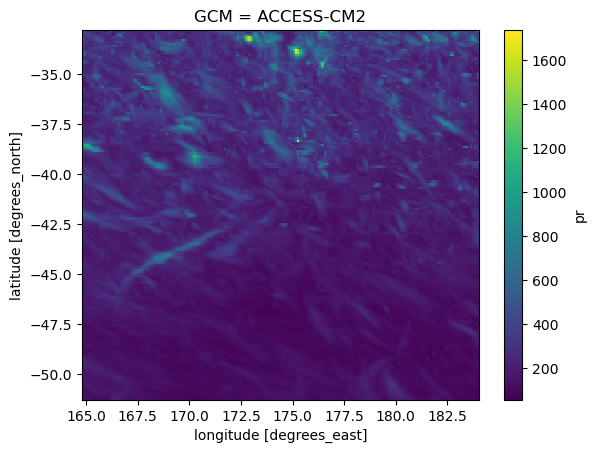

In [74]:
future_climo.pr.plot()

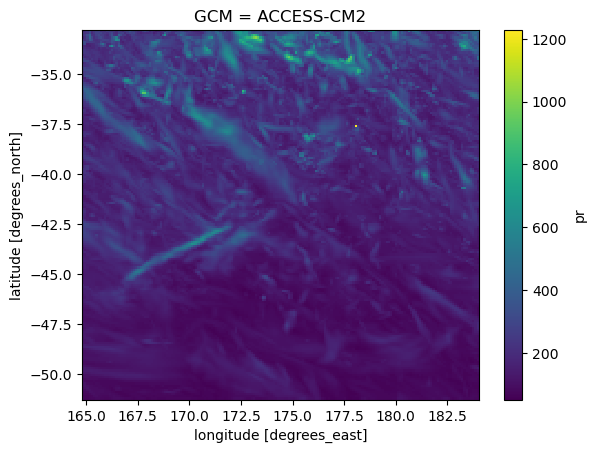

In [75]:
hist_climo.pr.plot()

In [76]:
cc_signal =100 * (future_climo - hist_climo)/hist_climo

In [77]:
cc_signal.pr.mean()

<xarray.DataArray 'pr' ()>
array(29.196846, dtype=float32)
Coordinates:
    GCM      <U10 'ACCESS-CM2'

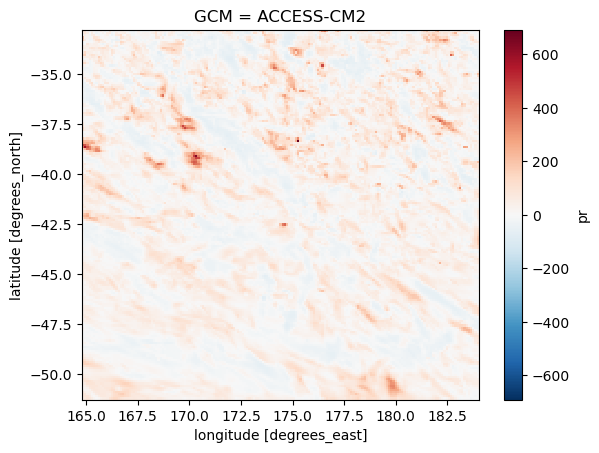

In [78]:
cc_signal.pr.plot()